# Machine Learning Projet

## 1.  Sujet et Contexte : Le trading Haute Fréquence

L'essor du trading haute fréquence (HFT), caractérisé par des transactions ultra-rapides et des infrastructures performantes, a particulièrement attiré l'attention des régulateurs et des chercheurs.

Les acteurs du marché, y compris les HFT, interagissent via le carnet d'ordres limite (LOB), où ils soumettent, modifient et annulent des ordres d'achat et de vente. La fragmentation des marchés, avec des titres négociés sur plusieurs plateformes, offre aux HFT des opportunités d'arbitrage grâce à leur rapidité.

L'objectif de ce projet est de développer un modèle de classification capable de distinguer trois catégories d'acteurs : HFT, non-HFT et Mix, en se basant sur des variables comportementales issues des données d'ordres et de transactions. 

## 2.  Importation des données

#### Import Packages

In [6]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [9]:
pip install umap

Note: you may need to restart the kernel to use updated packages.


In [10]:
# Importation des packages nécessaires
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC, SVR
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report, f1_score, log_loss, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import  RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
#from umap import UMAP
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score


#### Import données

In [11]:
# Importation des données 
df_x_train = pd.read_csv("X_train.csv", sep=",", header=0)
df_x_train.set_index('Index', inplace=True)
df_x_train.head()

,Share,Day,Trader,OTR,OCR,OMR,min_time_two_events,mean_time_two_events,10_p_time_two_events,med_time_two_events,...,min_dt_TV1_TV2,mean_dt_TV1_TV2,med_dt_TV1_TV2,min_dt_TV1_TV3,mean_dt_TV1_TV3,med_dt_TV1_TV3,min_dt_TV1_TV4,mean_dt_TV1_TV4,med_dt_TV1_TV4,NbSecondWithAtLeatOneTrade
Index,,,,,,,,,,,,,,,,,,,,,
1,Isin_8,Date_24,Trader_10,2.272727,8.333333,12.500000,0.0,5117.830300,0.000000,419.688500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
2,Isin_87,Date_29,Trader_10,1.696629,25.166667,21.571429,0.0,1846.968401,0.000074,0.003374,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15
3,Isin_87,Date_23,Trader_10,1.482759,47.300000,118.250000,0.0,686.300630,0.000071,0.000599,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63
4,Isin_12,Date_11,Trader_10,1.705882,14.500000,29.000000,0.0,2174.335265,0.000000,6.152666,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
5,Isin_87,Date_9,Trader_10,1.517730,26.750000,NaN,0.0,944.008551,0.000071,0.001364,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38


In [12]:
df_x_train.shape

(105782, 38)

Il y a 38 colonnes au total et 105 782 lignes.
Le nombre de lignes conséquent s'explique de la manière suivante : il y a i x a x t lignes, pour i traders, a actifs tradés, à t dates différentes. 
A première vue, nous pouvons déjà repérer des colonnes avec beaucoup de NaN / valeurs manquantes. 

En plus du nombre de traders, des dates, des ISINs sur lesquels les ordres sont passés, il y a également des statistiques par "trading venue", donc des plateformes de trading. Effectivement, un trader "Haute Fréquence" a plus de probabilités d'effectuer des trades sur plusieurs plateforme quasi-simultanément pour faire des arbitrages. 


Les données disponibles : 

- Share/ ISIN : code ISIN de l'actif tradé 
- Day : date du trade
- Trader : ID du trader pour l'identifier
- OTR : nombre de trades passés (sur cet ISIN, ce jour, par ce trader)
- OCR : nombre de trades annulés
- OMR : nombre de trades modifiés
- Colonnes 7 à 14 : statistiques descriptives sur le delta de temps entre deux trades
- Colonnes 15 à 22 : statistiques descriptives sur la durée de vie des ordres annulés sur la plateforme 1 
- NbTradeVenueMic : le nombre de plateformes où les traders opèrent en même temps à la date t
- Max et moyenne du nombre de trades par secondes
- Min, médiane, moyenne du delta de temps entre deux trades sur la plateforme 1
- Min, médiane, moyenne du delta de temps entre deux trades, un sur la plateforme 1 et l'autre sur plateforme 2
- Min, médiane, moyenne du delta de temps entre deux trades, un sur la plateforme 1 et l'autre sur plateforme 3
- Min, médiane, moyenne du delta de temps entre deux trades, un sur la plateforme 1 et l'autre sur plateforme 4
- Nombre de secondes avec au moins 1 trade


## 3. Analyse exploratoire et valeurs manquantes


#### 3.1 Valeurs manquantes

D'abord, nous faisons une étude des valeurs manquantes. 

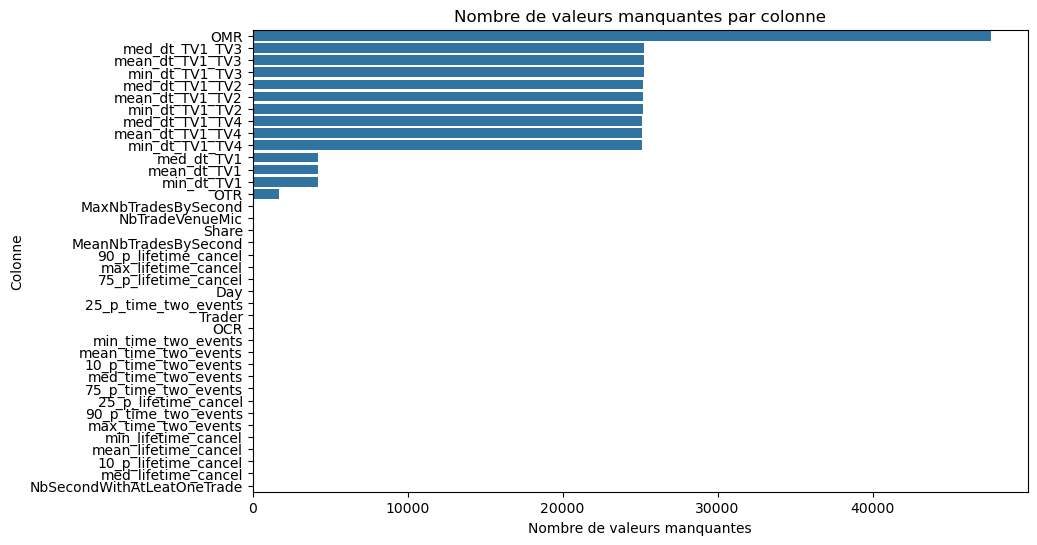

In [13]:
column_names = df_x_train.columns.tolist()
missing_values = df_x_train.isnull().sum()
missing_values_df = pd.DataFrame({'Column': column_names, 'Missing Values': missing_values})
missing_values_df = missing_values_df.sort_values(by='Missing Values', ascending=False)

# représentation graohique
plt.figure(figsize=(10, 6))
sns.barplot(x='Missing Values', y='Column', data=missing_values_df)
plt.title('Nombre de valeurs manquantes par colonne')
plt.xlabel('Nombre de valeurs manquantes')
plt.ylabel('Colonne')
plt.show()

Nous avons deux façons de traiter les valeurs manquantes : s'il y a trop de valeurs manquantes (plus de 3000 NaN), nous retirons la colonne, sinon, nous remplaçons les valeurs manquantes par les moyennes de la colonne par trader. 
C'est donc une moyenne un peu plus "personnalisée". 
Néanmoins, concernant les valeurs manquantes, nous remarquons que celles-ci sont principalement dans les colonnes liées aux trades sur plusieurs plateformes. Nous devons émettre l'hypothèse que ces colonnes seront remplies de NA si le trader n'opère que sur une plateforme à la fois. 
Nous allons donc vérifier cette hypothèse, avant de procéder au reste de l'analyse. 

Pour commencer, nous étudions la distribution du nombre de plateformes utilisées. 

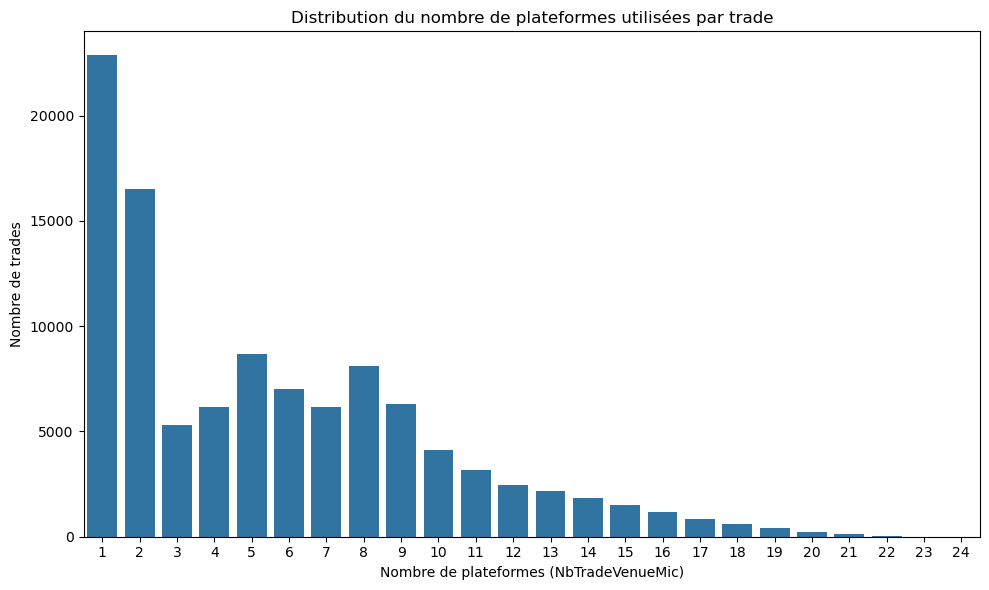

In [14]:
# 2. Analyse de la relation entre NbTradeVenueMic et les valeurs manquantes
plt.figure(figsize=(10, 6))
sns.countplot(x='NbTradeVenueMic', data=df_x_train)
plt.title('Distribution du nombre de plateformes utilisées par trade')
plt.xlabel('Nombre de plateformes (NbTradeVenueMic)')
plt.ylabel('Nombre de trades')
plt.tight_layout()
plt.show()

Désormais, nous allons regarder le lien entre NbTradeVenueMic (le nombre de plateformes) et les colonnes liées aux différentes plateformes (qui sont donc sujettes à de nombreux NA). 
Le résultat nous montre bien que les deux sont liés, donc que les NA sont le résultat de traders "monoplateforme". 
Afin de ne pas perdre cette information, en supprimant automatiquement les colonnes concernées, nous avons décidé de les retraiter en remplacant ces NA par 0. Effectivement, les colonnes "min_dt_TV" etc sont liées au delta de temps entre deux trades. S'il n'y a qu'une plateforme, alors c'est =0. 

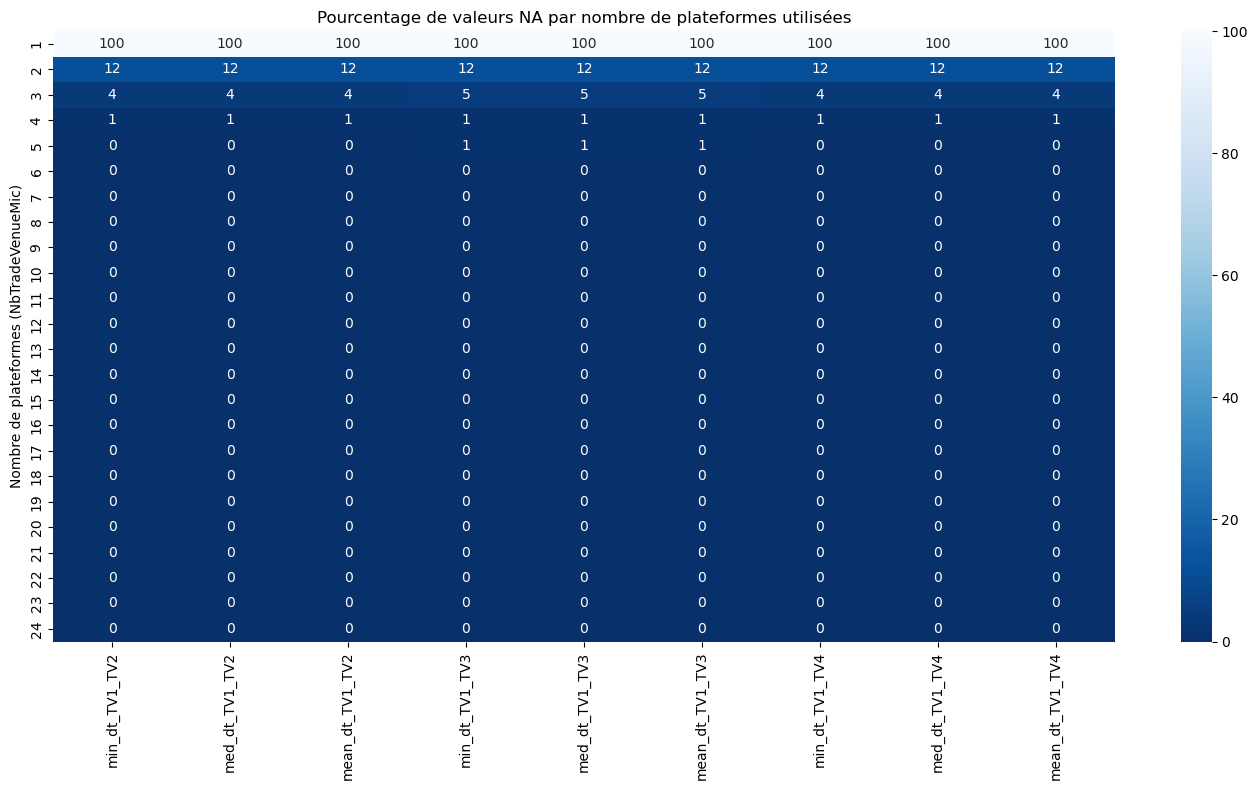

In [15]:
# analyser les patterns de NA par rapport à NbTradeVenueMic

platform_columns = [
    # Colonnes pour la plateforme 2
    'min_dt_TV1_TV2', 'med_dt_TV1_TV2', 'mean_dt_TV1_TV2',
    # Colonnes pour la plateforme 3
    'min_dt_TV1_TV3', 'med_dt_TV1_TV3', 'mean_dt_TV1_TV3',
    # Colonnes pour la plateforme 4
    'min_dt_TV1_TV4', 'med_dt_TV1_TV4', 'mean_dt_TV1_TV4'
]

na_mask = df_x_train[platform_columns].isnull()
# Puis groupons les valeurs nulles par NbTradeVenueMic
na_by_venues = na_mask.groupby(df_x_train['NbTradeVenueMic']).mean().round(2) * 100

# Visualiser cette relation
plt.figure(figsize=(14, 8))
sns.heatmap(na_by_venues, annot=True, cmap='Blues_r', fmt='.0f')
plt.title('Pourcentage de valeurs NA par nombre de plateformes utilisées')
plt.ylabel('Nombre de plateformes (NbTradeVenueMic)')
plt.tight_layout()
plt.show()

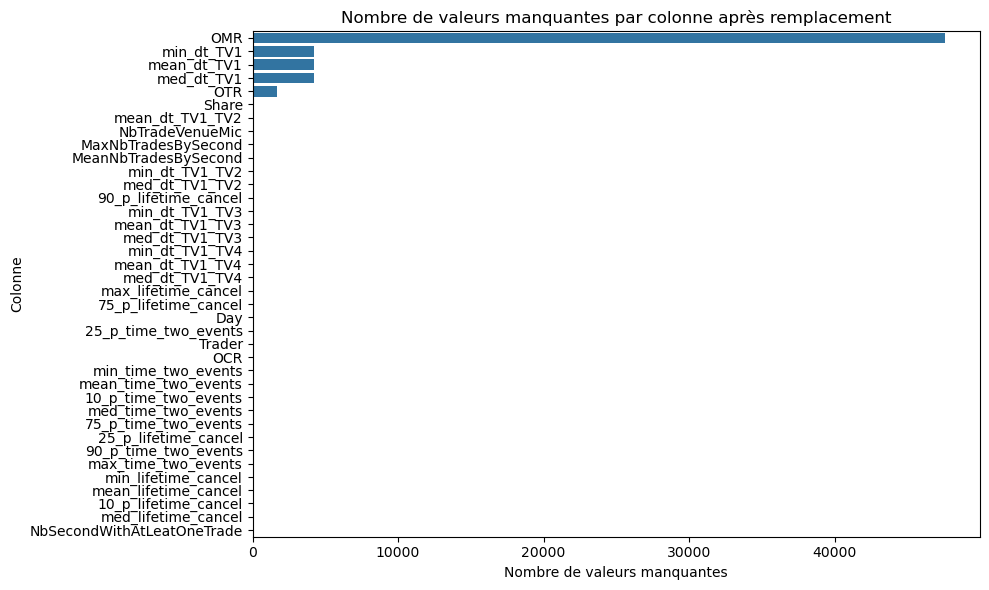

In [16]:
# 3. Remplacer les NA par 0 dans les colonnes pertinentes
df_x_train_filled = df_x_train.copy()

# Remplacer les NA par 0 dans ces colonnes
columns_to_fill = platform_columns 
df_x_train_filled[columns_to_fill] = df_x_train_filled[columns_to_fill].fillna(-1) 
# on remplace par -1 pour ne pas avoir l'erreur des NA mais on ne remplace pas par zéro car ça reviendrait à dire
# que le time delta c'est 0 alors qu'on n'a pas de time delta car on fonctionne sur une seule plateforme

# Vérifier le nombre de valeurs manquantes après remplacement
missing_values_after = df_x_train_filled.isnull().sum()
missing_values_after_df = pd.DataFrame({'Column': column_names, 'Missing Values': missing_values_after})
missing_values_after_df = missing_values_after_df.sort_values(by='Missing Values', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Missing Values', y='Column', data=missing_values_after_df)
plt.title('Nombre de valeurs manquantes par colonne après remplacement')
plt.xlabel('Nombre de valeurs manquantes')
plt.ylabel('Colonne')
plt.tight_layout()
plt.show()


In [17]:
def remove_NaN_columns(df):
    """
    Cette fonction modifie le DataFrame donné en argument en supprimant les colonnes
    qui contiennent uniquement des valeurs NaN.
    On utilise dropna avec axis=1 pour cibler les colonnes et how='all' pour supprimer
    les colonnes où toutes les valeurs sont NaN
    """
    
    nan_columns = df.columns[df.isna().all()]
    df = df.drop(nan_columns, axis=1, inplace=False)
    
    return df

def remove_Useless_columns(df, useless_columns):
    """
    Cette fonction modifie le DataFrame donné en argument en supprimant les colonnes
    qui ne sont pas nécessaires à l'analyse, aussi entrées en argument.
    On utilise encore la fonction dropna avec axis=1 mais cette fois en ciblant des colonnes spécifiques,
    on supprime les colonnes qui sont contenues dans le vecteur de chaînes de caractères "useless_columns".
    """
    
    df = df.drop(useless_columns, axis=1, inplace=False)
    
    return df

def remove_NaN_Rows(df):
    """
    Cette fonction modifie le DataFrame donné en argument en supprimant les lignes qui contiennent
    aucune valeur. Toujours en utilisant la fonction dropna mais cette fois en mettant 0 pour l'argument "axis"
    puisqu'on se concentre sur les lignes.
    """
    df = df.dropna(axis=0, how='all', inplace=False)
    
    return df

def find_columns_with_few_values(df, threshold=3000):
    """
    Identifie les colonnes d'un DataFrame contenant plus de 'threshold' valeurs manquantes.

    :param df: DataFrame Pandas
    :param threshold: Nombre maximal de valeurs manquantes pour qu'une colonne soit retenue (par défaut 1000)
    :return: Liste des colonnes ayant plus de 'threshold' valeurs manquantes
    """
    too_many_missing_columns = [col for col in df.columns if df[col].isnull().sum() > threshold]

    print("Colonnes à retirer : ")
    print(too_many_missing_columns)
    return too_many_missing_columns

def replace_nan_with_mean_or_empty(df):
    """
    Remplace les NaN par une valeur par défaut :
    - "" (chaîne vide) pour les colonnes de type texte (object ou string)
    - Moyenne de la colonne pour chaque trader pour les colonnes numériques

    :param df: DataFrame Pandas
    :return: DataFrame avec NaN remplacés
    """
    df_filled = df.copy()

    for col in df.columns:
        if df[col].dtype == 'object' or pd.api.types.is_string_dtype(df[col]):
            df_filled[col] = df[col].fillna("")
        elif pd.api.types.is_numeric_dtype(df[col]):
            # Calculer la moyenne par trader
            mean_by_trader = df.groupby('Trader')[col].transform('mean')
            df_filled[col] = df[col].fillna(mean_by_trader)

    return df_filled

def clean_data(df):
    """
    Cette fonction appelle toutes les focntions pour clean entièrement le DataFrame. 
    """
    df = remove_NaN_columns(df)
    few_values_columns = find_columns_with_few_values(df)
    df = remove_Useless_columns(df,few_values_columns)
    df = remove_NaN_Rows(df)
    df = replace_nan_with_mean_or_empty(df)
    
    return df


In [18]:
df_x_train_clean = clean_data(df_x_train_filled)
df_x_train_clean.head()


Colonnes à retirer : 
['OMR', 'min_dt_TV1', 'mean_dt_TV1', 'med_dt_TV1']


,Share,Day,Trader,OTR,OCR,min_time_two_events,mean_time_two_events,10_p_time_two_events,med_time_two_events,25_p_time_two_events,...,min_dt_TV1_TV2,mean_dt_TV1_TV2,med_dt_TV1_TV2,min_dt_TV1_TV3,mean_dt_TV1_TV3,med_dt_TV1_TV3,min_dt_TV1_TV4,mean_dt_TV1_TV4,med_dt_TV1_TV4,NbSecondWithAtLeatOneTrade
Index,,,,,,,,,,,,,,,,,,,,,
1,Isin_8,Date_24,Trader_10,2.272727,8.333333,0.0,5117.830300,0.000000,419.688500,10.722543,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,4
2,Isin_87,Date_29,Trader_10,1.696629,25.166667,0.0,1846.968401,0.000074,0.003374,0.000204,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,15
3,Isin_87,Date_23,Trader_10,1.482759,47.300000,0.0,686.300630,0.000071,0.000599,0.000129,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,63
4,Isin_12,Date_11,Trader_10,1.705882,14.500000,0.0,2174.335265,0.000000,6.152666,0.000945,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,4
5,Isin_87,Date_9,Trader_10,1.517730,26.750000,0.0,944.008551,0.000071,0.001364,0.000146,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,38


#### 3.2 Analyse exploratoire - traitement des doublons et outliers

Avant de pouvoir produire des premières statistiques, nous devons vérifier qu'il n'y ait pas de doublons, puis identifier et traiter les outliers. 

In [19]:
print("Nombre de doublons avant suppression :", df_x_train_clean.duplicated().sum())

# Suppression des doublons
df_x_train_clean = df_x_train_clean.drop_duplicates()
print("Nombre de doublons après suppression :", df_x_train_clean.duplicated().sum())

Nombre de doublons avant suppression : 19708
Nombre de doublons après suppression : 0


In [20]:
# Fonctions utilisées pour l'identification et le traitement des outliers

def plot_boxplot(df, cleaned=False, columns=None):
    """
    Affiche les boxplots pour les colonnes spécifiées d'un DataFrame.
    
    Paramètres:
    df (pandas.DataFrame): DataFrame à visualiser
    cleaned (bool): Indique si les données ont été nettoyées (pour le titre)
    columns (list, optional): Liste des colonnes à visualiser. Si None, toutes les colonnes numériques sont visualisées.
    """
    # Sélectionner les colonnes numériques si aucune colonne n'est spécifiée
    if columns is None:
        # Sélectionner toutes les colonnes numériques
        numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
    else:
        # Vérifier que les colonnes spécifiées existent dans le DataFrame
        existing_cols = [col for col in columns if col in df.columns]
        numeric_cols = [col for col in existing_cols if np.issubdtype(df[col].dtype, np.number)]
        
        if len(numeric_cols) == 0:
            print("Aucune des colonnes spécifiées n'est numérique ou présente dans le DataFrame.")
            return
        
        if len(numeric_cols) < len(columns):
            missing_cols = [col for col in columns if col not in existing_cols]
            print(f"Colonnes non trouvées ou non numériques: {missing_cols}")
    
    # Créer un titre en fonction de l'état des données
    title = "Distribution des variables (données "
    title += "nettoyées)" if cleaned else "brutes)"
    
    # Paramètres de la figure
    n_cols = min(3, len(numeric_cols)) 
    n_rows = (len(numeric_cols) + n_cols - 1) // n_cols 
    
    # Créer la figure
    plt.figure(figsize=(5*n_cols, 4*n_rows))
    plt.suptitle(title, fontsize=16)
    
    # Créer un boxplot pour chaque colonne numérique
    for i, col in enumerate(numeric_cols):
        plt.subplot(n_rows, n_cols, i+1)
        df[col].plot(kind='box')
        plt.title(col)
        plt.tight_layout(rect=[0, 0, 1, 0.95]) 
    
    plt.show()

    
def replace_outliers(df):
    """
    Remplace les outliers des colonnes numériques par la médiane de celles-ci.

    :param df: DataFrame Pandas
    :return: DataFrame nettoyé sans outliers
    """
    df_cleaned = df.copy()

    # Colonnes à exclure
    exclude_columns = ["Index", "share", "trader", "day"]

    # Sélection des colonnes numériques à traiter
    numeric_columns = [col for col in df.select_dtypes(include=[np.number]).columns if col not in exclude_columns]

    # Traitement pour chaque colonne numérique
    for col in numeric_columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        # Définition des bornes pour détecter les outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Identification des outliers
        mask = (df[col] < lower_bound) | (df[col] > upper_bound)
        median = df[col].median()
        
        # Remplacement des outliers par la médiane
        df_cleaned.loc[mask, col] = median

    return df_cleaned


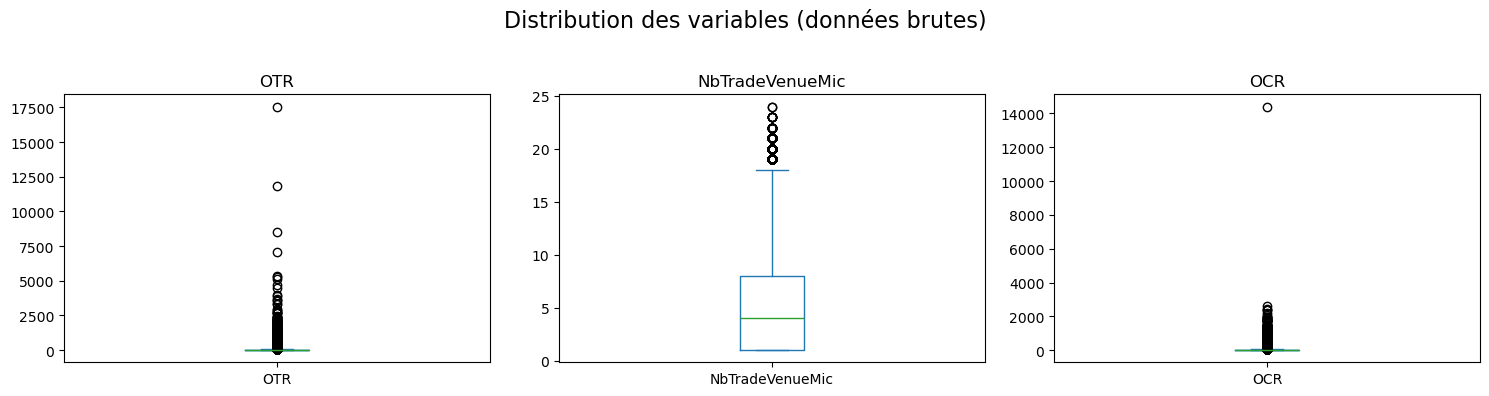

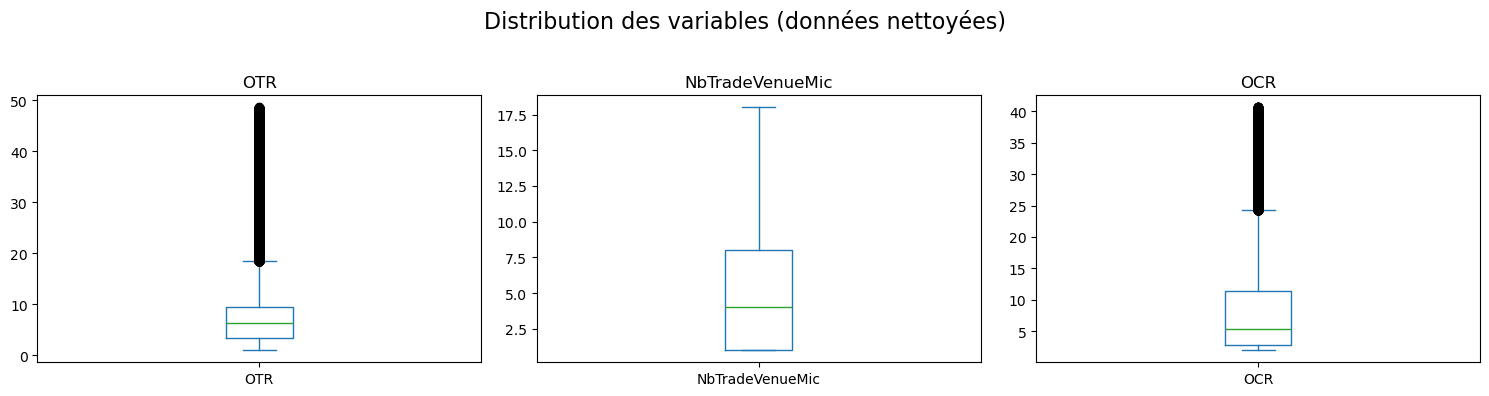

In [21]:

selected_columns = ['OTR', 'NbTradeVenueMic', 'OCR']  

# Données avant nettoyage
plot_boxplot(df_x_train_clean, cleaned=False, columns=selected_columns)

df_x_train_cleaned = pd.DataFrame()
df_x_train_cleaned = replace_outliers(df_x_train_clean)

plot_boxplot(df_x_train_cleaned, cleaned=True, columns=selected_columns)

On observe que le traitement des outliers a quelque peu amélioré la qualité des informations. 

In [22]:
# Séparation des colonnes numériques et non numériques
numeric_cols = df_x_train_cleaned.select_dtypes(include=['number']).columns
non_numeric_cols = df_x_train_cleaned.select_dtypes(exclude=['number']).columns
if 'Index' in df_x_train_cleaned.columns:
    numeric_cols = numeric_cols.drop('Index')
df_numeric = df_x_train_cleaned[numeric_cols]

global_stats = df_numeric.describe()
print("Statistiques descriptives globales : ")
global_stats


Statistiques descriptives globales : 


,OTR,OCR,min_time_two_events,mean_time_two_events,10_p_time_two_events,med_time_two_events,25_p_time_two_events,75_p_time_two_events,90_p_time_two_events,max_time_two_events,...,min_dt_TV1_TV2,mean_dt_TV1_TV2,med_dt_TV1_TV2,min_dt_TV1_TV3,mean_dt_TV1_TV3,med_dt_TV1_TV3,min_dt_TV1_TV4,mean_dt_TV1_TV4,med_dt_TV1_TV4,NbSecondWithAtLeatOneTrade
count,86074.000000,86074.000000,86074.0,86074.000000,86074.000000,86074.000000,86074.000000,86074.000000,86074.000000,86074.000000,...,86074.000000,86074.000000,86074.000000,86074.000000,86074.000000,86074.000000,86074.000000,86074.000000,86074.000000,86074.000000
mean,9.081293,8.736726,0.0,1267.830925,0.000606,17.030868,0.559313,305.809482,8203.747523,22010.848017,...,-0.274772,91.601235,21.020332,-0.274766,92.230336,21.431544,-0.273580,93.012710,21.430706,124.438878
std,9.368348,8.796958,0.0,2122.994144,0.002100,26.793661,1.330792,717.905873,12594.481592,17632.708254,...,0.471361,134.006694,38.879938,0.472885,135.763769,39.585405,0.472018,136.345315,39.499112,153.642024
min,1.044444,2.000000,0.0,0.000065,0.000000,0.000000,0.000000,0.000000,0.000000,0.000065,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000
25%,3.483871,2.819390,0.0,63.576481,0.000000,1.082370,0.000020,21.030420,108.986441,2965.041500,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,19.000000
50%,6.375000,5.352005,0.0,238.444058,0.000084,10.060465,0.068556,107.796205,406.280622,24258.458000,...,0.000011,52.195819,7.765250,0.000014,51.319869,7.969500,0.000059,52.587646,8.098514,80.000000
75%,9.476278,11.398592,0.0,1277.599518,0.000109,16.582077,0.162414,156.779063,16264.428500,35726.220750,...,0.000147,110.586712,20.009234,0.000161,111.190220,20.468828,0.000222,112.099718,20.388401,158.000000
max,48.577928,40.600000,0.0,8666.805079,0.018359,152.300600,7.353152,4566.284000,44014.297000,71934.490000,...,1.495748,636.878625,196.933116,1.502560,644.656900,202.713587,1.502560,649.437327,201.628556,704.000000


#### 3.3 Standarisation des données

On remarque que les ordres de grandeurs sont dispersés. Certains algorithmes de ML nécessitent la standarisation des données afin d'avoir des orders de grandeur similaires.

In [23]:
"""
 Est-ce qu'on garde la standardisation des données sachant qu'il a dit qu'en finance
 c'était pas forcément ce qu'il y avait de mieux à faire ?
"""

numeric_cols = df_x_train_cleaned.select_dtypes(include=['number']).columns
non_numeric_cols = df_x_train_cleaned.select_dtypes(exclude=['number']).columns

# Standardisation manuelle avec Z-score 
numeric_cols = df_x_train_cleaned.select_dtypes(include=['number']).columns
non_numeric_cols = df_x_train_cleaned.select_dtypes(exclude=['number']).columns

df_x_train_standardized=df_x_train_clean.copy()
df_x_train_standardized[numeric_cols] = (df_x_train_clean[numeric_cols] - df_x_train_clean[numeric_cols].mean()) / df_x_train_clean[numeric_cols].std()

# Numérisation des colonnes Share, Day et Trader
df_x_train_standardized["Share"] = pd.to_numeric(df_x_train_standardized["Share"].str.extract('(\d+)').squeeze())  
df_x_train_standardized["Day"] = pd.to_numeric(df_x_train_standardized["Day"].str.extract('(\d+)').squeeze())  
df_x_train_standardized["Trader"] = pd.to_numeric(df_x_train_standardized["Trader"].str.extract('(\d+)').squeeze())  

print("données standarisées : ")
df_x_train_standardized.head()

données standarisées : 


,Share,Day,Trader,OTR,OCR,min_time_two_events,mean_time_two_events,10_p_time_two_events,med_time_two_events,25_p_time_two_events,...,min_dt_TV1_TV2,mean_dt_TV1_TV2,med_dt_TV1_TV2,min_dt_TV1_TV3,mean_dt_TV1_TV3,med_dt_TV1_TV3,min_dt_TV1_TV4,mean_dt_TV1_TV4,med_dt_TV1_TV4,NbSecondWithAtLeatOneTrade
Index,,,,,,,,,,,,,,,,,,,,,
1,8,24,10,-0.224634,-0.135860,-0.060054,0.510256,-0.068497,-0.113027,-0.099851,...,-0.148045,-0.25924,-0.186751,-0.150765,-0.258271,-0.188015,-0.15138,-0.261887,-0.18939,-0.486551
2,87,29,10,-0.228865,0.077696,-0.060054,-0.161096,-0.068496,-0.200434,-0.104299,...,-0.148045,-0.25924,-0.186751,-0.150765,-0.258271,-0.188015,-0.15138,-0.261887,-0.18939,-0.468171
3,87,23,10,-0.230436,0.358491,-0.060054,-0.399326,-0.068496,-0.200435,-0.104299,...,-0.148045,-0.25924,-0.186751,-0.150765,-0.258271,-0.188015,-0.15138,-0.261887,-0.18939,-0.387968
4,12,11,10,-0.228797,-0.057627,-0.060054,-0.093904,-0.068497,-0.199153,-0.104299,...,-0.148045,-0.25924,-0.186751,-0.150765,-0.258271,-0.188015,-0.15138,-0.261887,-0.18939,-0.486551
5,87,9,10,-0.230179,0.097783,-0.060054,-0.346431,-0.068496,-0.200434,-0.104299,...,-0.148045,-0.25924,-0.186751,-0.150765,-0.258271,-0.188015,-0.15138,-0.261887,-0.18939,-0.429740


#### 3.4 Statistiques descriptives sur le DataFrame propre

In [24]:
### Statistiques descriptives PAR trader #####
# Calcul des stats
stats_by_trader = df_x_train_cleaned.groupby("Trader")[numeric_cols].describe()
print("Statistiques descriptives par trader : ")
print(stats_by_trader)
stats_by_trader.to_csv("stats_by_trader.csv")


Statistiques descriptives par trader : 
               OTR                                                    \
             count      mean       std       min       25%       50%   
Trader                                                                 
Trader_10     77.0  2.133353  1.283060  1.233129  1.529126  1.696629   
Trader_105  2052.0  5.399858  3.765703  1.354430  3.321553  4.322540   
Trader_107  1836.0  3.661004  1.324899  1.193548  2.758549  3.557418   
Trader_110     8.0  3.508333  1.472688  1.333333  2.850000  3.166667   
Trader_114  2217.0  4.987915  3.633552  1.250000  3.035714  3.928571   
...            ...       ...       ...       ...       ...       ...   
Trader_51    143.0  3.984287  2.991443  1.333333  2.193750  3.000000   
Trader_54    290.0  2.895337  2.148443  1.218750  1.913949  2.333333   
Trader_57     26.0  2.962073  1.196302  1.421053  2.050000  2.833333   
Trader_59     15.0  3.208786  2.702190  1.250000  1.608902  2.000000   
Trader_60     23.0  1.31

In [25]:
### Statistiques descriptives sur l'ensemble des traders ####
# Quartiles 15%, 75%, mediane, mean, max, min 
overall_stats = df_x_train_cleaned[numeric_cols].describe(percentiles=[0.15, 0.25, 0.5, 0.75])
print("Statistiques descriptives sur l'ensemble des traders : ")
overall_stats

#si l'on souhaite importer en CSV
#overall_stats.to_csv("overall_stats.csv")

Statistiques descriptives sur l'ensemble des traders : 


,OTR,OCR,min_time_two_events,mean_time_two_events,10_p_time_two_events,med_time_two_events,25_p_time_two_events,75_p_time_two_events,90_p_time_two_events,max_time_two_events,...,min_dt_TV1_TV2,mean_dt_TV1_TV2,med_dt_TV1_TV2,min_dt_TV1_TV3,mean_dt_TV1_TV3,med_dt_TV1_TV3,min_dt_TV1_TV4,mean_dt_TV1_TV4,med_dt_TV1_TV4,NbSecondWithAtLeatOneTrade
count,86074.000000,86074.000000,86074.0,86074.000000,86074.000000,86074.000000,86074.000000,86074.000000,86074.000000,86074.000000,...,86074.000000,86074.000000,86074.000000,86074.000000,86074.000000,86074.000000,86074.000000,86074.000000,86074.000000,86074.000000
mean,9.081293,8.736726,0.0,1267.830925,0.000606,17.030868,0.559313,305.809482,8203.747523,22010.848017,...,-0.274772,91.601235,21.020332,-0.274766,92.230336,21.431544,-0.273580,93.012710,21.430706,124.438878
std,9.368348,8.796958,0.0,2122.994144,0.002100,26.793661,1.330792,717.905873,12594.481592,17632.708254,...,0.471361,134.006694,38.879938,0.472885,135.763769,39.585405,0.472018,136.345315,39.499112,153.642024
min,1.044444,2.000000,0.0,0.000065,0.000000,0.000000,0.000000,0.000000,0.000000,0.000065,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000
15%,2.812500,2.261650,0.0,34.696250,0.000000,0.101911,0.000000,8.724534,44.647953,921.262278,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,8.000000
25%,3.483871,2.819390,0.0,63.576481,0.000000,1.082370,0.000020,21.030420,108.986441,2965.041500,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,19.000000
50%,6.375000,5.352005,0.0,238.444058,0.000084,10.060465,0.068556,107.796205,406.280622,24258.458000,...,0.000011,52.195819,7.765250,0.000014,51.319869,7.969500,0.000059,52.587646,8.098514,80.000000
75%,9.476278,11.398592,0.0,1277.599518,0.000109,16.582077,0.162414,156.779063,16264.428500,35726.220750,...,0.000147,110.586712,20.009234,0.000161,111.190220,20.468828,0.000222,112.099718,20.388401,158.000000
max,48.577928,40.600000,0.0,8666.805079,0.018359,152.300600,7.353152,4566.284000,44014.297000,71934.490000,...,1.495748,636.878625,196.933116,1.502560,644.656900,202.713587,1.502560,649.437327,201.628556,704.000000


#### 3.5 Etude des corrélations entre variables (numériques)

Nous avons fait une heatmap pour étudier les corrélations entre les variables. Cela devrait nous aider à faire des choix sur les features à conserver, et si l'on souhaite en ajouter.

In [26]:
df_x_train_cleaned["min_time_two_events"].head()

Index
1    0.0
2    0.0
3    0.0
4    0.0
5    0.0
Name: min_time_two_events, dtype: float64

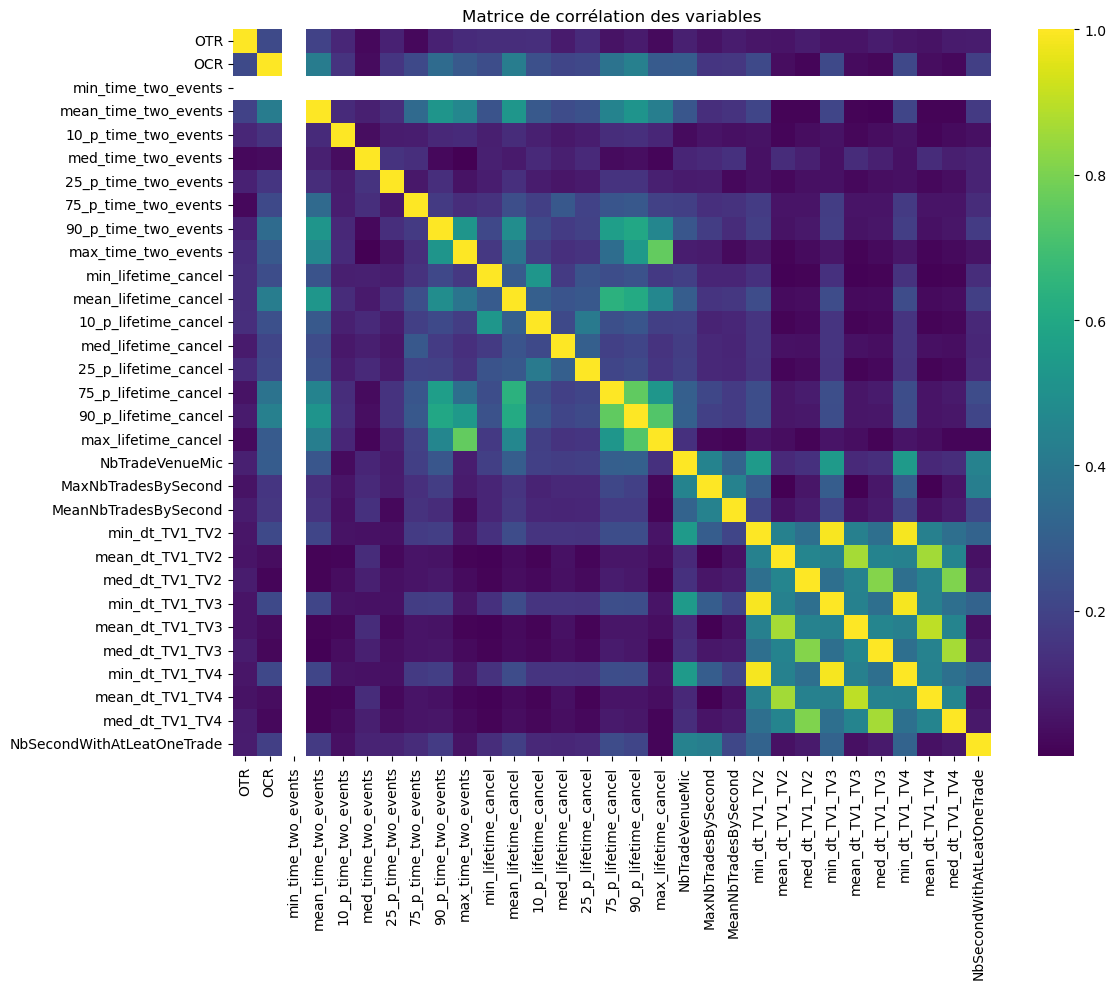

In [27]:
corr_matrix = df_x_train_cleaned[numeric_cols].corr().abs()

# Visualiser la matrice de corrélation
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='viridis', vmax=1.0)
plt.title('Matrice de corrélation des variables')
plt.tight_layout()
plt.show()



La heatmap nous permet d'identifier très rapidement quelles variables semblent fortement corrélées. Par exemple, les statistiques (moyenne, minimum etc) sur le delta de temps entre deux trades sont particulièrement corrélées. De même, les statistiques liées aux évènements d'annluation d'un ordre sont très corréléses. Ce qui est plutôt logique, car ce sont des variables qui décrivent le même évènement/ la même variable. 
Nous pourrions donc réduire considérablement la taille de notre dataframe, et donc sélectionner les features qui nous semblent les plus pertiennts. 
Pour cela, nous allons faire une Analyse en Composantes Principales (ACP), qui nous permettra de sélectionner les features les plus "utiles".

## 4. Modèle Supervisé / Entraînement sur plusieurs modèles

Nous voulons explorer les différents modèles sur notre base de données nettoyée. Néanmoins, nous commençons par ne pas inclure les features, afin d'avoir une première approche "exploratoire" des modèles. 

#### Préparation des données

Il est nécessaire de retravailler les set de données X et Y train avant de pouvoir débuter nos analyses de modèle. 
Nous remarquons une problématique : nos datasets ont des tailles très très différentes. Effectivement, y contient une partie des labels des traders avec leurs ID pour les identifier. Or, comme nous l'avions déjà mentionné, X a une taille de a x i x t, pour a traders, i ISINs et t dates. y a en comparaison une taille de a lignes. 

Le deuxième potentiel problème concerne la classfication entre HFT, non HFT et MIX. Nous devons les transformer en code (numérique).

In [41]:
X = df_x_train_cleaned
y = pd.read_csv("Y_train.csv") 

# dimensions 
print(X.shape)
print(y.shape)

(86074, 34)
(86, 2)


In [42]:
label_encoder = LabelEncoder()
y['type'] = label_encoder.fit_transform(y['type'])
print("Mapping des classes :", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

Mapping des classes : {'HFT': 0, 'MIX': 1, 'NON HFT': 2}


In [43]:
# 1. Merge des données sur la colonne 'Trader'
full_data = pd.merge(X, y, on='Trader', how='left')

# 2. Création d'un ID neutre (un simple index unique)
full_data.reset_index(drop=True, inplace=True)
full_data['sample_id'] = full_data.index

# 3. Séparation des labels et des features, mais en conservant les ID des traders
y = full_data['type'].copy()
trader_ids = full_data['Trader'].copy()  # On conserve les ID des traders
X = full_data.drop(['type'], axis=1).copy()  # On garde 'Trader' et 'sample_id' pour référence

# Numérisation des colonnes Share, Day et Trader
X["Share"] = pd.to_numeric(X["Share"].str.extract('(\d+)').squeeze())
X["Day"] = pd.to_numeric(X["Day"].str.extract('(\d+)').squeeze())

# 4. Séparation simultanée des données, des labels et des ID des traders
X_train, X_test, y_train, y_test, trader_ids_train, trader_ids_test = train_test_split(
    X.drop(['Trader', 'sample_id'], axis=1), y, trader_ids, test_size=0.2, random_state=42, stratify=y)

# Conserver les sample_id dans des variables séparées si nécessaire
sample_ids_train = X_train.index
sample_ids_test = X_test.index


Nous adoptons une approche qui est propre à notre problème, c'est-à-dire un problème de classification de traders entre 3 catégories. 

Pour cela, nous avons donc adapté la fonction evaluate_model pour qu'elle retourne les statistiques qui nous semblent pertinentes : 
- Accuracy : proportion de prédictions correctes parmi toutes les prédictions. C'est la précision globale du modèle
- F1-score : moyenne harmonique entre précision et rappel
- log-loss : mesure l'incertitude des prédications. 

En faisant tourner les modèles plusieurs fois, nous nous sommes rendu compte que l'utilisation d'une cross-validation = 5 avait tendance à nous bloquer complètement, et mettait plusieurs heures à tourner. Donc nous avons choisi de réduire à 3. 
De même, afin de faire tourner le code plus vite, nous avons décidé d'une sample-size d'un sous-échantille pour la validation croisée. Enfin, evaluate_model a 3 modes plus ou moins détaillés pour ressortir plus ou moins de statistiques. 

In [44]:
# Fonction pour évaluer un modèle de classification
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    print(f"Début du run du modèle {model_name}...")
    start_time = time.time()
    
    # Entraînement et prédiction du modèle
    model.fit(X_train, y_train)
    print("modèle fit, on commence la prédiction")
    y_pred = model.predict(X_test)
    print("Prédiction terminée, on passe à cross validation... Nous en sommes à : (s)")
    print(time.time()-start_time)

    # Métriques de classification
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted') # Pondéré pour gestion multi-classes

    # Pour les modèles qui supportent les probabilités, calculer le log loss
    try:
        y_pred_proba = model.predict_proba(X_test)
        log_loss_value = log_loss(y_test, y_pred_proba)
    except:
        log_loss_value = None

    # Validation croisée pour l'accuracy
    cv_scores = cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy')
    cv_accuracy = cv_scores.mean()
    
    # Temps total d'exécution
    total_time = time.time() - start_time

    # Affichage d'un rapport détaillé
    print(f"\n--- {model_name} ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score (weighted): {f1:.4f}")
    print(f"Cross-Validation Accuracy: {cv_accuracy:.4f}")

    if log_loss_value is not None:
        print(f"Log Loss: {log_loss_value:.4f}")
        print(f"Temps d'exécution: {total_time:.2f} secondes")
        print("\nRapport de classification:")
        print(classification_report(y_test, y_pred))

    # Matrice de confusion et graphique
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(7, 3))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel('Prédit')
    plt.ylabel('Véritable')
    plt.title(f'Matrice de confusion pour {model_name}')
    plt.show()
    
    # Retourner un dictionnaire avec toutes les métriques
    return {
    'Modèle': model_name,
    'Accuracy': accuracy,
    'F1-score': f1,
    'CV Accuracy': cv_accuracy,
    'Log Loss': log_loss_value,
    'Temps total (s)': total_time
    }

#### Tests de différents modèles 

Pour les modèles supervisés, nous testons plusieurs modèles différents. Le but étant de voir lequel a le meilleur accuracy score, le meilleur F1 score. 

Voici un aperçu des modèles testés. 
Modèles classiques : 
- Logistic regression : utilisé pour les problèmes de classification binaire et peut être étendue à des classifications multiclass (via l'approche "one-vs-rest" par exemple).Elle est particulièrement utile pour estimer la probabilité qu'une observation appartienne à une classe spécifique. C'est un modèle facile à interpréter, ce qui aide à comprendre quels facteurs sont les plus influents dans la classification des traders.
- Random Forest : ensemble d'arbres de décision, généralement entraînés avec la méthode de "bagging". Il fournit également une bonne indication de l'importance des features, ce qui peut être utile pour analyser quelles caractéristiques contribuent le plus à la classification des traders.
- Gradient Boosting : Le Gradient Boosting construit un modèle additif de manière progressive; il commence par un modèle basique et ajoute de manière itérative des corrections, souvent sous la forme d'arbres de décision, en minimisant une fonction de perte spécifiée.
- Naive Bayes :  c'est une famille de classificateurs probabilistes basés sur le théorème de Bayes avec l'hypothèse "naïve" d'indépendance entre les features. Il fonctionne bien sur des données catégorielles et est efficace pour les problèmes de classification simple où les relations linéaires entre les paramètres ne sont pas attendues.
Modèles avancés : 
- CatBoost : Implémentation optimisée du gradient boosting spécialement conçue pour gérer efficacement les variables catégorielles. 
- AdaBoost : Méthode d'ensemble qui ajuste la pondération des observations mal classées à chaque itération.
- Decision Tree : Modèle de segmentation hiérarchique des données. Mais tendance au surapprentissage et instabilité. 
- KNN Classifier : Classification basée sur la proximité avec les exemples d'entraînement.
- LightGBM : Version allégée et optimisée du gradient boosting. 
- XGBoost : Implémentation hautement optimisée du gradient boosting.


Début du run du modèle Logistic Regression...
modèle fit, on commence la prédiction
Prédiction terminée, on passe à cross validation... Nous en sommes à : (s)
17.891964197158813

--- Logistic Regression ---
Accuracy: 0.7581
F1 Score (weighted): 0.7520
Cross-Validation Accuracy: 0.7562
Log Loss: 0.5812
Temps d'exécution: 45.56 secondes

Rapport de classification:
              precision    recall  f1-score   support

           0       0.69      0.53      0.60      4507
           1       0.74      0.82      0.78      8261
           2       0.84      0.87      0.86      4447

    accuracy                           0.76     17215
   macro avg       0.76      0.74      0.74     17215
weighted avg       0.75      0.76      0.75     17215



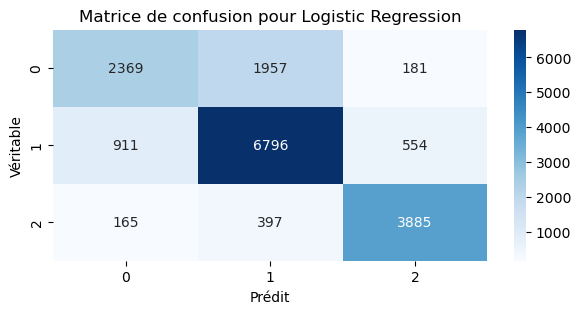

Début du run du modèle Random Forest...
modèle fit, on commence la prédiction
Prédiction terminée, on passe à cross validation... Nous en sommes à : (s)
1.8846850395202637

--- Random Forest ---
Accuracy: 0.9424
F1 Score (weighted): 0.9423
Cross-Validation Accuracy: 0.9416
Log Loss: 0.1967
Temps d'exécution: 5.25 secondes

Rapport de classification:
              precision    recall  f1-score   support

           0       0.97      0.90      0.93      4507
           1       0.93      0.97      0.95      8261
           2       0.94      0.94      0.94      4447

    accuracy                           0.94     17215
   macro avg       0.95      0.94      0.94     17215
weighted avg       0.94      0.94      0.94     17215



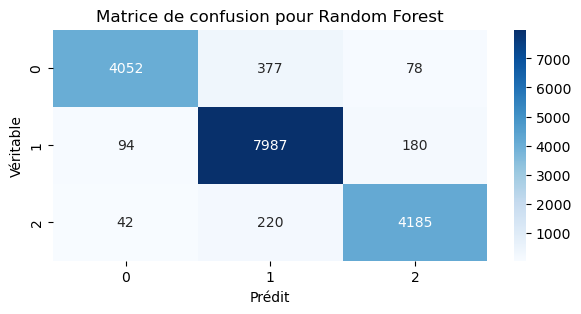

Début du run du modèle Gradient Boosting...
modèle fit, on commence la prédiction
Prédiction terminée, on passe à cross validation... Nous en sommes à : (s)
67.74566197395325

--- Gradient Boosting ---
Accuracy: 0.9244
F1 Score (weighted): 0.9242
Cross-Validation Accuracy: 0.9230
Log Loss: 0.2410
Temps d'exécution: 201.56 secondes

Rapport de classification:
              precision    recall  f1-score   support

           0       0.95      0.87      0.91      4507
           1       0.92      0.95      0.93      8261
           2       0.92      0.94      0.93      4447

    accuracy                           0.92     17215
   macro avg       0.93      0.92      0.92     17215
weighted avg       0.92      0.92      0.92     17215



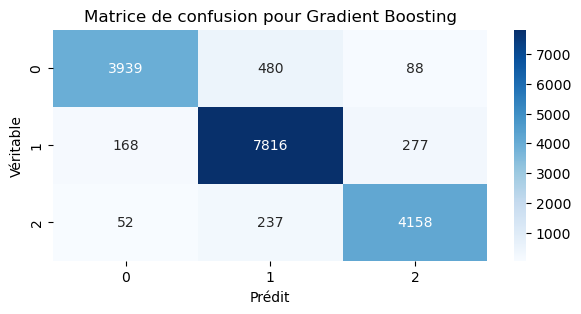

Début du run du modèle Naive Bayes...
modèle fit, on commence la prédiction
Prédiction terminée, on passe à cross validation... Nous en sommes à : (s)
0.08351993560791016

--- Naive Bayes ---
Accuracy: 0.7058
F1 Score (weighted): 0.7063
Cross-Validation Accuracy: 0.7040
Log Loss: 2.0298
Temps d'exécution: 0.19 secondes

Rapport de classification:
              precision    recall  f1-score   support

           0       0.55      0.69      0.61      4507
           1       0.81      0.62      0.70      8261
           2       0.75      0.88      0.81      4447

    accuracy                           0.71     17215
   macro avg       0.70      0.73      0.71     17215
weighted avg       0.73      0.71      0.71     17215



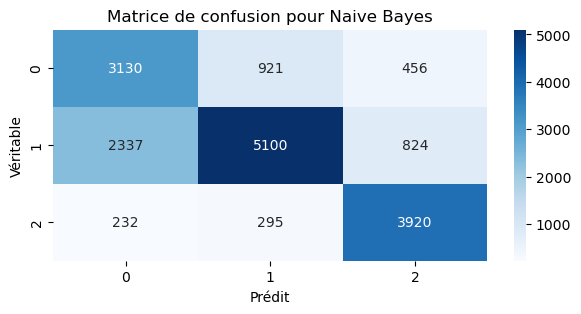

Début du run du modèle CatBoost...
modèle fit, on commence la prédiction
Prédiction terminée, on passe à cross validation... Nous en sommes à : (s)
1.8241117000579834

--- CatBoost ---
Accuracy: 0.9415
F1 Score (weighted): 0.9414
Cross-Validation Accuracy: 0.9396
Log Loss: 0.1864
Temps d'exécution: 4.94 secondes

Rapport de classification:
              precision    recall  f1-score   support

           0       0.95      0.91      0.93      4507
           1       0.94      0.96      0.95      8261
           2       0.94      0.94      0.94      4447

    accuracy                           0.94     17215
   macro avg       0.94      0.94      0.94     17215
weighted avg       0.94      0.94      0.94     17215



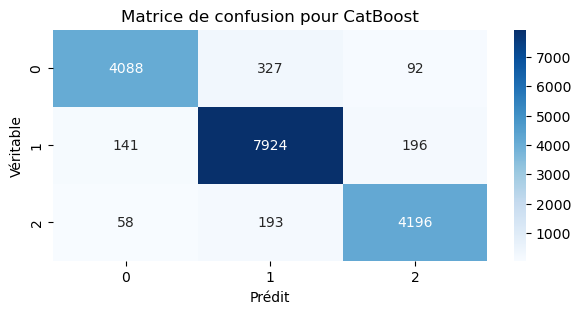

Début du run du modèle AdaBoost...
modèle fit, on commence la prédiction
Prédiction terminée, on passe à cross validation... Nous en sommes à : (s)
17.52705979347229

--- AdaBoost ---
Accuracy: 0.8478
F1 Score (weighted): 0.8476
Cross-Validation Accuracy: 0.8443
Log Loss: 1.0243
Temps d'exécution: 53.13 secondes

Rapport de classification:
              precision    recall  f1-score   support

           0       0.87      0.82      0.84      4507
           1       0.88      0.82      0.85      8261
           2       0.79      0.93      0.85      4447

    accuracy                           0.85     17215
   macro avg       0.84      0.86      0.85     17215
weighted avg       0.85      0.85      0.85     17215



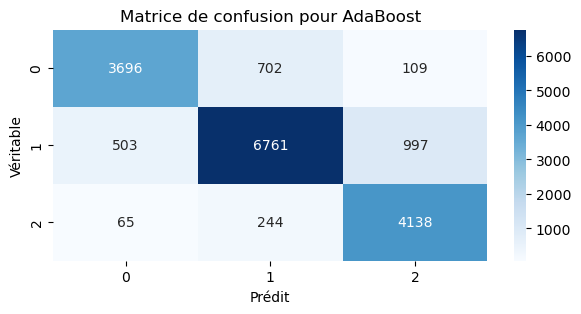

Début du run du modèle Decision tree...
modèle fit, on commence la prédiction
Prédiction terminée, on passe à cross validation... Nous en sommes à : (s)
1.491239070892334

--- Decision tree ---
Accuracy: 0.9299
F1 Score (weighted): 0.9297
Cross-Validation Accuracy: 0.9282
Log Loss: 0.4881
Temps d'exécution: 4.41 secondes

Rapport de classification:
              precision    recall  f1-score   support

           0       0.94      0.89      0.91      4507
           1       0.92      0.95      0.94      8261
           2       0.94      0.93      0.94      4447

    accuracy                           0.93     17215
   macro avg       0.93      0.92      0.93     17215
weighted avg       0.93      0.93      0.93     17215



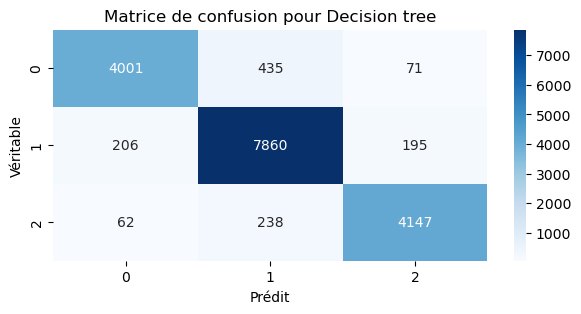

Début du run du modèle KNN classifier...
modèle fit, on commence la prédiction
Prédiction terminée, on passe à cross validation... Nous en sommes à : (s)
0.8485960960388184

--- KNN classifier ---
Accuracy: 0.8481
F1 Score (weighted): 0.8482
Cross-Validation Accuracy: 0.8420
Log Loss: 1.7867
Temps d'exécution: 3.91 secondes

Rapport de classification:
              precision    recall  f1-score   support

           0       0.81      0.83      0.82      4507
           1       0.87      0.84      0.86      8261
           2       0.85      0.87      0.86      4447

    accuracy                           0.85     17215
   macro avg       0.84      0.85      0.85     17215
weighted avg       0.85      0.85      0.85     17215



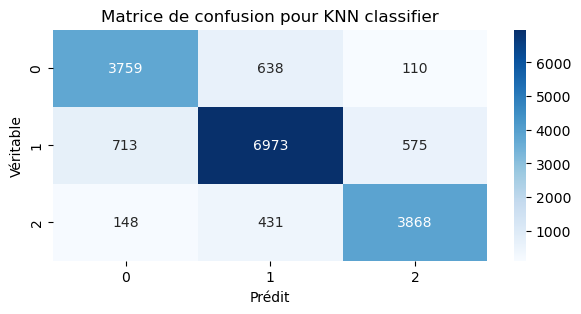

Début du run du modèle XGBoost...


/Users/ally/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:34:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


modèle fit, on commence la prédiction
Prédiction terminée, on passe à cross validation... Nous en sommes à : (s)
1.027721881866455


/Users/ally/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:34:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ally/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:34:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ally/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:34:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



--- XGBoost ---
Accuracy: 0.9334
F1 Score (weighted): 0.9332
Cross-Validation Accuracy: 0.9315
Log Loss: 0.2105
Temps d'exécution: 3.19 secondes

Rapport de classification:
              precision    recall  f1-score   support

           0       0.95      0.89      0.92      4507
           1       0.93      0.95      0.94      8261
           2       0.93      0.94      0.93      4447

    accuracy                           0.93     17215
   macro avg       0.94      0.93      0.93     17215
weighted avg       0.93      0.93      0.93     17215



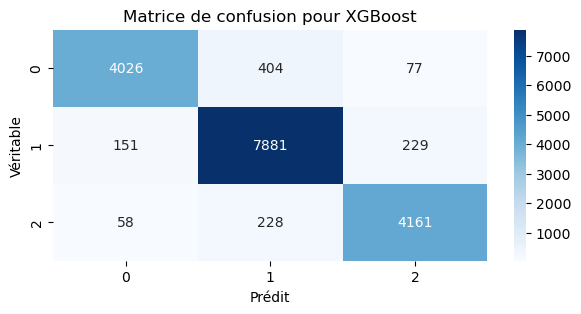

In [27]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=500, solver='liblinear'),
    'Random Forest': RandomForestClassifier(n_estimators=50, max_depth=10, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=50, max_depth=3),
    'Naive Bayes': GaussianNB(),
    'CatBoost': CatBoostClassifier(iterations=100, learning_rate=0.1, depth=6, random_seed=42, thread_count=-1, verbose=0),
    'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=42),
    'Decision tree': DecisionTreeClassifier(max_depth=10, random_state=42),
    'KNN classifier': KNeighborsClassifier(n_neighbors=5, algorithm='kd_tree', n_jobs=-1),
    'XGBoost': XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42, n_jobs=-1, 
                          use_label_encoder=False, eval_metric='mlogloss'),
    #'LightGBM': LGBMClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42, n_jobs=-1),
}


# Évaluer tous les modèles
results = []
for name, model in models.items():
    result = evaluate_model(model, X_train, X_test, y_train, y_test, name)
    results.append(result)

# Créer un DataFrame pour les résultats
results_df = pd.DataFrame(results)

# Trier par accuracy décroissante
results_df_sorted = results_df.sort_values(by='Accuracy', ascending=False)

# Récupérer le meilleur modèle et le second meilleur modèle
best_model_name = results_df_sorted.iloc[0]['Modèle']
second_best_model_name = results_df_sorted.iloc[1]['Modèle']

# Nous isolons le modèle random forest pour le benchmark
rf_model = models['Random Forest']

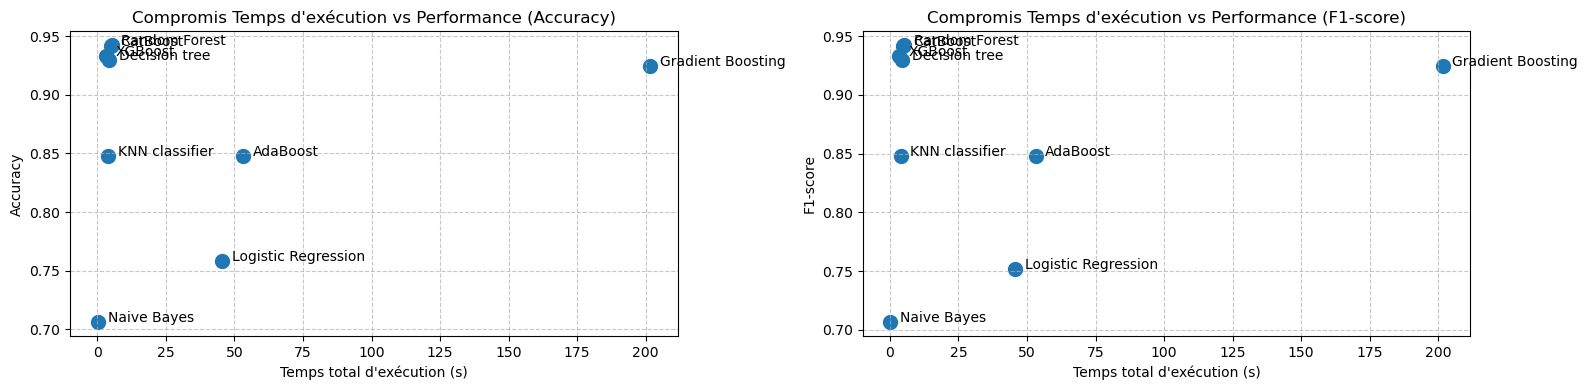


Tableau comparatif final trié par Accuracy:
                Modèle  Accuracy  F1-score  CV Accuracy  Temps total (s)
1        Random Forest  0.942434  0.942282     0.941562         5.245372
4             CatBoost  0.941505  0.941393     0.939645         4.941022
8              XGBoost  0.933372  0.933229     0.931469         3.192548
6        Decision tree  0.929887  0.929719     0.928158         4.411562
2    Gradient Boosting  0.924368  0.924157     0.922959       201.564836
7       KNN classifier  0.848098  0.848189     0.841967         3.909850
5             AdaBoost  0.847807  0.847613     0.844305        53.127225
0  Logistic Regression  0.758060  0.751975     0.756197        45.564625
3          Naive Bayes  0.705780  0.706300     0.703960         0.190497


In [29]:
# Création d'une figure pour contenir les deux graphiques
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

# Graphique 1 : Temps vs Accuracy
axes[0].scatter(results_df['Temps total (s)'], results_df['Accuracy'], s=100)
for i, txt in enumerate(results_df['Modèle']):
    axes[0].annotate(txt, (results_df['Temps total (s)'].iloc[i], results_df['Accuracy'].iloc[i]),
                     xytext=(7, 0), textcoords='offset points')
axes[0].set_title("Compromis Temps d'exécution vs Performance (Accuracy)")
axes[0].set_xlabel('Temps total d\'exécution (s)')
axes[0].set_ylabel('Accuracy')
axes[0].grid(True, linestyle='--', alpha=0.7)

# Graphique 2 : Temps vs F1-score
axes[1].scatter(results_df['Temps total (s)'], results_df['F1-score'], s=100)
for i, txt in enumerate(results_df['Modèle']):
    axes[1].annotate(txt, (results_df['Temps total (s)'].iloc[i], results_df['F1-score'].iloc[i]),
                     xytext=(7, 0), textcoords='offset points')
axes[1].set_title("Compromis Temps d'exécution vs Performance (F1-score)")
axes[1].set_xlabel('Temps total d\'exécution (s)')
axes[1].set_ylabel('F1-score')
axes[1].grid(True, linestyle='--', alpha=0.7)

# Affichage des deux graphiques côte à côte
plt.tight_layout()
plt.show()

# Tableau final avec les performances et le temps total
final_comparison = results_df[['Modèle', 'Accuracy', 'F1-score', 'CV Accuracy', 'Temps total (s)']]

print("\nTableau comparatif final trié par Accuracy:")
print(final_comparison.sort_values(by='Accuracy', ascending=False))


#### Ancienne version 

Nous avons choisi de laisser les outputs de l'ancienne version, pour montrer l'amélioration du temps d'exécution. 

Début du run du modèle AdaBoost...
modèle fit, on commence la prédiction
Prédiction terminée, on passe à cross validation... Nous en sommes à : (s)
17.922285079956055

--- AdaBoost ---
Accuracy: 0.8478
F1 Score (weighted): 0.8476
Cross-Validation Accuracy: 0.8443
Log Loss: 1.0243
Temps d'exécution: 53.29 secondes

Rapport de classification:
              precision    recall  f1-score   support

           0       0.87      0.82      0.84      4507
           1       0.88      0.82      0.85      8261
           2       0.79      0.93      0.85      4447

    accuracy                           0.85     17215
   macro avg       0.84      0.86      0.85     17215
weighted avg       0.85      0.85      0.85     17215



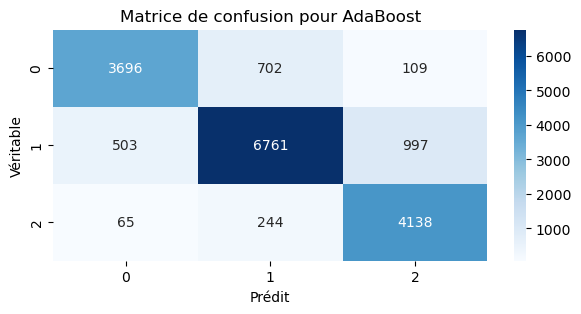

Début du run du modèle Decision tree...
modèle fit, on commence la prédiction
Prédiction terminée, on passe à cross validation... Nous en sommes à : (s)
1.5491771697998047

--- Decision tree ---
Accuracy: 0.9299
F1 Score (weighted): 0.9297
Cross-Validation Accuracy: 0.9282
Log Loss: 0.4881
Temps d'exécution: 4.34 secondes

Rapport de classification:
              precision    recall  f1-score   support

           0       0.94      0.89      0.91      4507
           1       0.92      0.95      0.94      8261
           2       0.94      0.93      0.94      4447

    accuracy                           0.93     17215
   macro avg       0.93      0.92      0.93     17215
weighted avg       0.93      0.93      0.93     17215



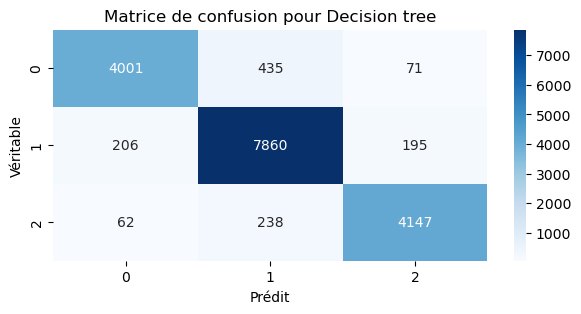

Début du run du modèle KNN classifier...
modèle fit, on commence la prédiction
Prédiction terminée, on passe à cross validation... Nous en sommes à : (s)
0.9968788623809814

--- KNN classifier ---
Accuracy: 0.8481
F1 Score (weighted): 0.8482
Cross-Validation Accuracy: 0.8420
Log Loss: 1.7867
Temps d'exécution: 4.57 secondes

Rapport de classification:
              precision    recall  f1-score   support

           0       0.81      0.83      0.82      4507
           1       0.87      0.84      0.86      8261
           2       0.85      0.87      0.86      4447

    accuracy                           0.85     17215
   macro avg       0.84      0.85      0.85     17215
weighted avg       0.85      0.85      0.85     17215



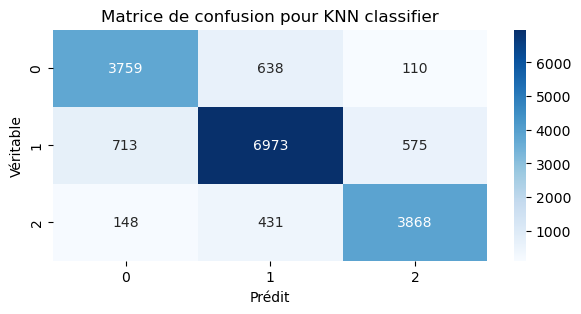

Début du run du modèle LightGBM ...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006823 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7363
[LightGBM] [Info] Number of data points in the train set: 68859, number of used features: 32
[LightGBM] [Info] Start training from score -1.340079
[LightGBM] [Info] Start training from score -0.734221
[LightGBM] [Info] Start training from score -1.353649
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

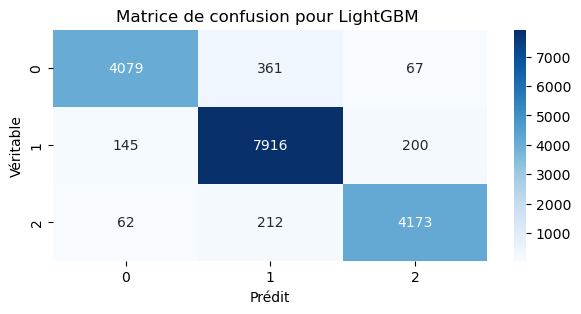

Début du run du modèle XGBoost...


/Users/ally/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:00:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


modèle fit, on commence la prédiction
Prédiction terminée, on passe à cross validation... Nous en sommes à : (s)
1.0788938999176025


/Users/ally/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:00:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ally/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:00:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ally/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:00:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



--- XGBoost ---
Accuracy: 0.9334
F1 Score (weighted): 0.9332
Cross-Validation Accuracy: 0.9315
Log Loss: 0.2105
Temps d'exécution: 3.40 secondes

Rapport de classification:
              precision    recall  f1-score   support

           0       0.95      0.89      0.92      4507
           1       0.93      0.95      0.94      8261
           2       0.93      0.94      0.93      4447

    accuracy                           0.93     17215
   macro avg       0.94      0.93      0.93     17215
weighted avg       0.93      0.93      0.93     17215



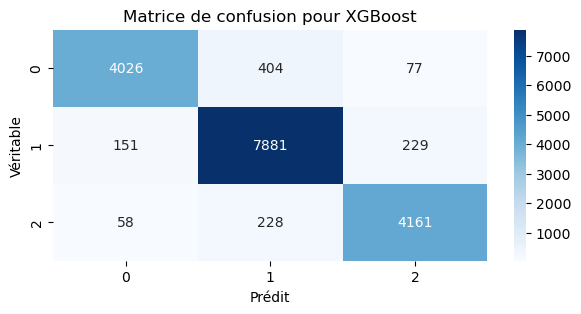

In [ ]:

models = {
    'Logistic Regression': LogisticRegression(max_iter=500, solver='liblinear'),
    'Random Forest': RandomForestClassifier(n_estimators=50, max_depth=10, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=50, max_depth=3),
    'Naive Bayes': GaussianNB(), 
    'CatBoost': CatBoostClassifier(iterations=100, learning_rate=0.1, depth=6,random_seed=42, thread_count=-1, verbose=0),
    'AdaBoost' : AdaBoostClassifier(n_estimators=100, random_state=42),
    'Decision tree' : DecisionTreeClassifier(max_depth=10, random_state=42),
    'KNN classifier' :KNeighborsClassifier(n_neighbors=5, algorithm='kd_tree', n_jobs=-1),
    'LightGBM ': LGBMClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42, n_jobs=-1),
    'XGBoost' : XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42, n_jobs=-1, use_label_encoder=True, eval_metric='mlogloss')
}

# Évaluer tous les modèles
results = []
for name, model in models.items():
    result = evaluate_model(model, X_train, X_test, y_train, y_test, name)
    results.append(result)

# Créer un DataFrame pour les résultats
results_df = pd.DataFrame(results)

# Trier par accuracy décroissante
results_df_sorted = results_df.sort_values(by='Accuracy', ascending=False)

# Récupérer le meilleur modèle et le second meilleur modèle
best_model_name = results_df_sorted.iloc[0]['Modèle']
second_best_model_name = results_df_sorted.iloc[1]['Modèle']

# Nous isolons le modèle random forest pour le benchmark
rf_model = models['Random Forest']


#### Grid search et optimisation des hyperparamètres



Démarrage de la recherche aléatoire...
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math 

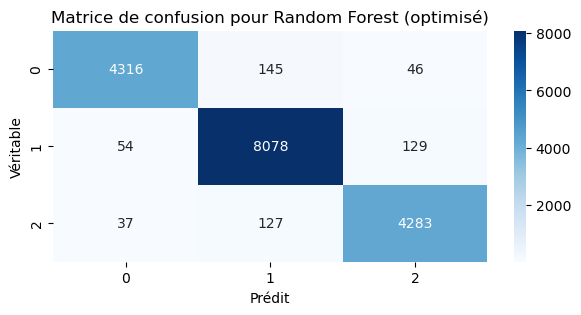

Démarrage de la recherche aléatoire...
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Meilleurs paramètres pour CatBoost:
    learning_rate: 0.1
    l2_leaf_reg: 1
    iterations: 200
    depth: 6
Début du run du modèle CatBoost (optimisé)...
modèle fit, on commence la prédiction
Prédiction terminée, on passe à cross validation... Nous en sommes à : (s)
2.8559410572052

--- CatBoost (optimisé) ---
Accuracy: 0.9561
F1 Score (weighted): 0.9560
Cross-Validation Accuracy: 0.9552
Log Loss: 0.1375
Temps d'exécution: 9.64 secondes

Rapport de classification:
              precision    recall  f1-score   support

           0       0.96      0.93      0.95      4507
           1       0.96      0.97      0.96      8261
           2       0.95      0.96      0.95      4447

    accuracy                           0.96     17215
   macro avg       0.96      0.95      0.95     17215
weighted avg       0.96      0.96      0.96     17215



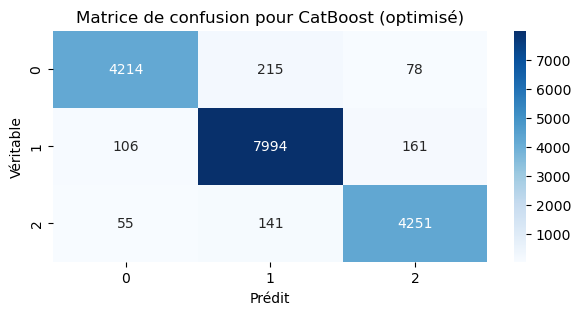


Résultats finaux après optimisation:
                      Modèle  Accuracy  F1-score  CV Accuracy  Temps total (s)
9   Random Forest (optimisé)  0.968748  0.968739     0.966991        26.558877
10       CatBoost (optimisé)  0.956085  0.956047     0.955227         9.635330
1              Random Forest  0.942434  0.942282     0.941562         5.245372
4                   CatBoost  0.941505  0.941393     0.939645         4.941022
8                    XGBoost  0.933372  0.933229     0.931469         3.192548
6              Decision tree  0.929887  0.929719     0.928158         4.411562
2          Gradient Boosting  0.924368  0.924157     0.922959       201.564836
7             KNN classifier  0.848098  0.848189     0.841967         3.909850
5                   AdaBoost  0.847807  0.847613     0.844305        53.127225
0        Logistic Regression  0.758060  0.751975     0.756197        45.564625
3                Naive Bayes  0.705780  0.706300     0.703960         0.190497


In [30]:
# Définition des grilles de paramètres pour différents modèles
param_grids = {
    'Logistic Regression': {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear'],
        'max_iter': [500, 1000]
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 10, 15, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]
    },
    'Gradient Boosting': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'max_depth': [3, 4, 5],
        'min_samples_split': [2, 5, 10],
        'subsample': [0.8, 0.9, 1.0]
    },
    'Naive Bayes': {
        'var_smoothing': np.logspace(0, -9, 10)
    },
    'CatBoost': {
        'iterations': [50, 100, 200],
        'learning_rate': [0.01, 0.05, 0.1],
        'depth': [4, 6, 8],
        'l2_leaf_reg': [1, 3, 5, 7]
    },
    'LightGBM': {
        'n_estimators': [30, 50, 100],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'num_leaves': [31, 50, 100],
        'feature_fraction': [0.7, 0.8, 0.9]
    },
    'XGBoost': {
        'n_estimators': [30, 50, 100],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'min_child_weight': [1, 3, 5],
        'gamma': [0, 0.1, 0.2],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0]
    }
}

if best_model_name in param_grids:
    best_model = models[best_model_name]
    param_grid = param_grids[best_model_name]
    
    # Configuration spéciale pour XGBoost si nécessaire
    if best_model_name == 'XGBoost':
        if hasattr(best_model, 'get_params'):
            model_params = best_model.get_params()
            if 'use_label_encoder' not in model_params or model_params['use_label_encoder'] is not False:
                best_model.set_params(use_label_encoder=False)
            if 'eval_metric' not in model_params:
                best_model.set_params(eval_metric='mlogloss')
    
    # Utiliser RandomizedSearchCV pour accélérer la recherche
    random_search = RandomizedSearchCV(
        estimator=best_model,
        param_distributions=param_grid,
        n_iter=15,  # Nombre d'itérations
        cv=3,
        scoring='accuracy',  # ou 'f1_weighted' pour un score F1 pondéré
        verbose=1,
        n_jobs=-1,
        random_state=42
    )
    
    print("Démarrage de la recherche aléatoire...")
    random_search.fit(X_train, y_train)
    
    # Récupérer les meilleurs paramètres et le meilleur modèle
    best_params = random_search.best_params_
    best_estimator = random_search.best_estimator_
    
    print(f"Meilleurs paramètres pour {best_model_name}:")
    for param, value in best_params.items():
        print(f"    {param}: {value}")
    
    # Évaluer le modèle optimisé en utilisant votre fonction evaluate_model
    optimized_result = evaluate_model(best_estimator, X_train, X_test, 
                                     y_train, y_test, 
                                     f"{best_model_name} (optimisé)")
    
    # Ajouter le résultat optimisé
    results.append(optimized_result)
else:
    print(f"Pas de grille de paramètres définie pour {best_model_name}")

# 2. Optimisation du second meilleur modèle

if second_best_model_name in param_grids:
    second_best_model = models[second_best_model_name]
    param_grid = param_grids[second_best_model_name]
    
    # Configuration spéciale pour XGBoost si nécessaire
    if second_best_model_name == 'XGBoost':
        if hasattr(second_best_model, 'get_params'):
            model_params = second_best_model.get_params()
            if 'use_label_encoder' not in model_params or model_params['use_label_encoder'] is not False:
                second_best_model.set_params(use_label_encoder=False)
            if 'eval_metric' not in model_params:
                second_best_model.set_params(eval_metric='mlogloss')
    
    # Utiliser RandomizedSearchCV pour accélérer la recherche
    random_search = RandomizedSearchCV(
        estimator=second_best_model,
        param_distributions=param_grid,
        n_iter=15,  # Nombre d'itérations
        cv=3,
        scoring='accuracy',  # ou 'f1_weighted' pour un score F1 pondéré
        verbose=1,
        n_jobs=-1,
        random_state=42
    )
    
    print("Démarrage de la recherche aléatoire...")
    random_search.fit(X_train, y_train)
    
    # Récupérer les meilleurs paramètres et le meilleur modèle
    best_params = random_search.best_params_
    best_estimator = random_search.best_estimator_
    
    print(f"Meilleurs paramètres pour {second_best_model_name}:")
    for param, value in best_params.items():
        print(f"    {param}: {value}")
    
    # Évaluer le modèle optimisé en utilisant votre fonction evaluate_model
    optimized_result = evaluate_model(best_estimator, X_train, X_test, 
                                     y_train, y_test, 
                                     f"{second_best_model_name} (optimisé)")
    
    # Ajouter le résultat optimisé
    results.append(optimized_result)
else:
    print(f"Pas de grille de paramètres définie pour {second_best_model_name}")

# Créer un DataFrame à partir des résultats
results_df = pd.DataFrame(results)

# Nouveau tri incluant les modèles optimisés
final_comparison = results_df.sort_values(by='Accuracy', ascending=False)

print("\nRésultats finaux après optimisation:")
print(final_comparison[['Modèle', 'Accuracy', 'F1-score', 'CV Accuracy', 'Temps total (s)']])


**Résultats**

Nous identifier CatBoost et Random Forest optimisés comme étant les plus performants en terme d'accuracy, ainsi que de F1-score, qui est la métrique utilisée par les créateurs du challenge dans leur benchmark. 
Effectivement, nous remarquons que nos deux meilleurs modèles sont Random Forest et Catboost, le second ayant un meilleur rapport performance/temps. Au contraire, ce sont les modèles Logistic Regression et Naive Bayes qui performent le moins bien dans notre cas. 


Nous notons néanmoins que l'optimisation des hyperparamètres a été efficace, car elle a amélioré les performances, justifiant par la même occasion le temps supplémentaire d'entraînement. De plus, le F1-score est proche de l'accuracy, ce qui suggère que notre modèle gère bien toutes les classes, sans trop de biais. 


Les scores de validation croisée sont proches de l'accuracy d'entraînement, ce qui signifie que nous avons une bonne généralisation. 


Comme les deux modèles sont tout de même assez rapides (moins de 30 secondes chacun), nous pouvons "choisir" Random Forest comme étant le meilleur modèle. Néanmoins, s'ils avaient eu des écarts de temps supérieur, nous aurions surement davantage mis en avant CatBoost, qui a un score légèrement moins bon, mais qui est beaucoup plus rapide. 


**Etude des Matrices de confusion**

Nous avons dans nos données davantages de Traders Mix, comparés aux traders HF et non-HF. 
Pour le Random Forest, la classe 1 (MIX) a le plus de précision, à hauteur de 98%. Pour le Catboost également, les prédictuons sont les plus justes sur la classe 1, et le plus d'erreurs sont commises sur la classe 0 (non-HF). 


C'est cette classe qui présente le plus d'erreurs pour les deux modèles. 
Enfin, sur les types d'erreurs, les confusions sont les plus nombreuses entre MIX et chacun des autres. Cela est plutôt cohérent avec nos données : il y a plus de probabilités de confondre un trader MIX avec un trader HF ou non-HF, plutôt que de confondre un trader Haute Fréquence avec un non Haute Fréquence. 

## 5. Benchmark 

Le benchmark nous est donné dans le challenge. Il est décrit de la façon suivante : 
Un modèle de forêt aléatoire simple, complété par des règles supplémentaires basées sur des seuils, a été utilisé pour déterminer le pourcentage de lignes par acteur du marché qui les classifie dans une des catégories, produisant un score F1 micro-moyenné d'environ 90%. Pour ce modèle « naïf », nous avons considéré qu'un acteur du marché est :

- un participant HFT si au moins 85% de ses prédictions sont classées comme HFT,
- un participant MIX si au moins 50% de ses prédictions sont classées comme MIX,

Dans les autres cas, le modèle classe l'acteur du marché comme NON HFT.

#### Modèle de Random Forest avec des règles spécifiques

In [45]:
# 5. Récupérer le modèle Random Forest et l'entraîner
rf_model = RandomForestClassifier(n_estimators=50, max_depth=10, n_jobs=-1)
rf_model.fit(X_train, y_train)

# 6. Faire des prédictions
y_pred = rf_model.predict(X_test)


In [46]:
# Dimension de nos prédictions 
print(y_pred)
print(y_pred.shape)

# En toute logique, les indices des traders (leur emplacement dans le dataframe), n'a pas changé. 
# Nous devons donc "rattacher" les ID traders, afin de pouvoir appliquer les règles établies dans le benchmark
print("\n--- Évaluation du modèle Random Forest (sans règles) ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nRapport de classification:")
print(classification_report(y_test, y_pred))
print("\nMatrice de confusion:")
print(confusion_matrix(y_test, y_pred))



[1 0 0 ... 2 1 0]
(17215,)

--- Évaluation du modèle Random Forest (sans règles) ---
Accuracy: 0.9413

Rapport de classification:
              precision    recall  f1-score   support

           0       0.97      0.90      0.93      4507
           1       0.93      0.97      0.95      8261
           2       0.94      0.94      0.94      4447

    accuracy                           0.94     17215
   macro avg       0.95      0.93      0.94     17215
weighted avg       0.94      0.94      0.94     17215


Matrice de confusion:
[[4039  390   78]
 [  90 7978  193]
 [  40  219 4188]]


In [ ]:

# Fonction pour appliquer les règles supplémentaires basées sur les seuils pour ajuster les prédictions
def apply_rules(traders, predictions):
    unique_traders = traders.unique()
    results = pd.Series(index=traders.index, dtype=str)
    
    for trader in unique_traders:
        idx = traders[traders == trader].index
        pred_counts = np.bincount(predictions[idx], minlength=3)
        
        if pred_counts.sum() > 0:
            pred_fractions = pred_counts / pred_counts.sum()
            
            if pred_fractions[0] >= 0.85:
                results[idx] = 'HFT'
            elif pred_fractions[1] >= 0.50:
                results[idx] = 'MIX'
            else:
                results[idx] = 'NON HFT'
    
    return results


# Réinitialiser les indices pour s'assurer qu'ils sont alignés
trader_ids_test_reset = trader_ids_test.reset_index(drop=True)
y_pred_series = pd.Series(y_pred)  # Convertir le tableau numpy en Series

# Appliquer les règles
refined_predictions = apply_rules(trader_ids_test_reset, y_pred_series)

y_test_categories = pd.Series(index=y_test.index, dtype=str)
if y_test.dtypes == 'int64' or y_test.dtypes == 'float64':
    y_test_categories[y_test == 0] = 'HFT'
    y_test_categories[y_test == 1] = 'MIX' 
    y_test_categories[y_test == 2] = 'NON HFT'
else:
    y_test_categories = y_test  # Si déjà sous forme de texte

# 10. Évaluer les prédictions après application des règles
print("\n--- Évaluation après application des règles ---")
print(f"Accuracy: {accuracy_score(y_test_categories, refined_predictions):.4f}")
print("\nRapport de classification:")
print(classification_report(y_test_categories, refined_predictions))



--- Évaluation après application des règles ---
Accuracy: 0.9531

Rapport de classification:
              precision    recall  f1-score   support

         HFT       1.00      0.84      0.91      4507
         MIX       0.99      1.00      1.00      8261
     NON HFT       0.85      0.99      0.92      4447

    accuracy                           0.95     17215
   macro avg       0.95      0.94      0.94     17215
weighted avg       0.96      0.95      0.95     17215


Matrice de confusion:
[[3781    0  726]
 [   0 8225   36]
 [   0   46 4401]]


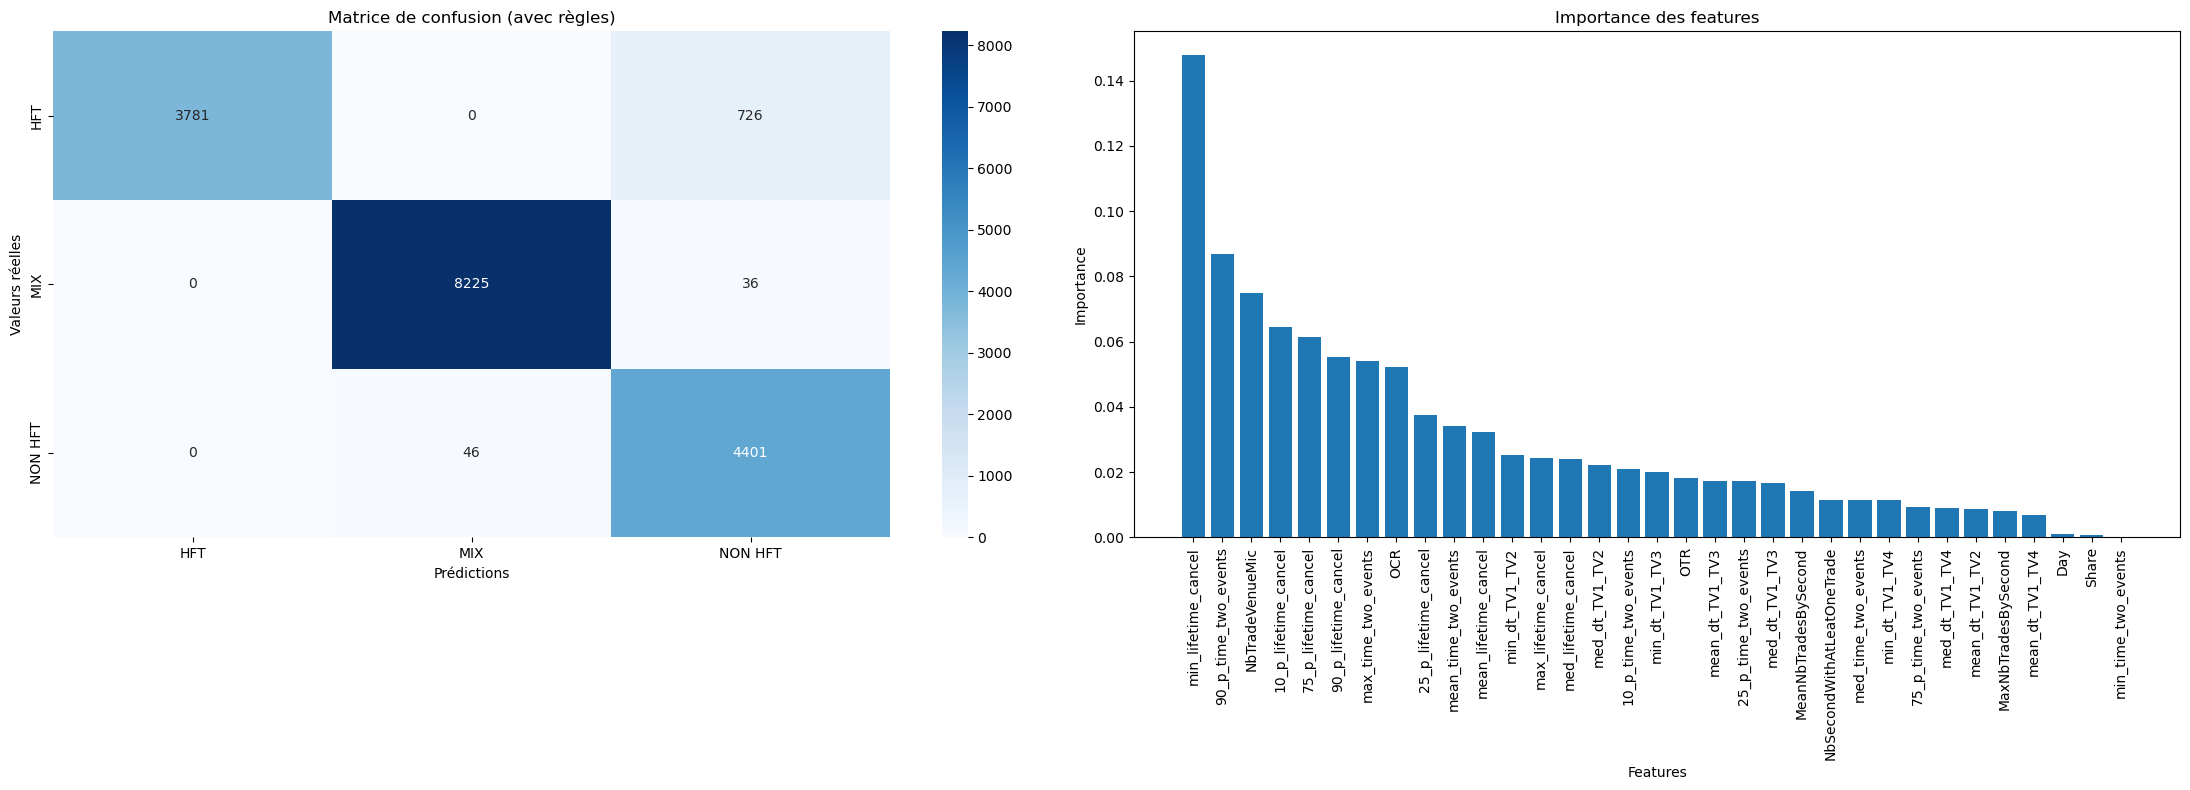

F1 Score (Micro): 0.9530641882079581
              precision    recall  f1-score   support

         HFT       1.00      0.84      0.91      4507
         MIX       0.99      1.00      1.00      8261
     NON HFT       0.85      0.99      0.92      4447

    accuracy                           0.95     17215
   macro avg       0.95      0.94      0.94     17215
weighted avg       0.96      0.95      0.95     17215


--- Comparaison avant/après règles ---
F1 Score sans règles: 0.942550101655533
F1 Score avec règles: 0.9530641882079581


In [48]:
# Créer et ajuster le LabelEncoder avec les classes possibles
label_encoder = LabelEncoder()
label_encoder.fit(['HFT', 'MIX', 'NON HFT'])  # Ajustez selon vos classes réelles

# Encoder y_test et refined_predictions si nécessaire
if isinstance(y_test.iloc[0], str):
    y_test_encoded = label_encoder.transform(y_test)
else:
    y_test_encoded = y_test.copy()
    
if isinstance(refined_predictions.iloc[0], str):
    refined_predictions_encoded = label_encoder.transform(refined_predictions)
else:
    refined_predictions_encoded = refined_predictions.copy()

# Matrice de confusion
cm = confusion_matrix(y_test_encoded, refined_predictions_encoded)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(22, 8))

# Matrice de confusion
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', 
           xticklabels=label_encoder.classes_, 
           yticklabels=label_encoder.classes_, 
           ax=axes[0])
axes[0].set_title('Matrice de confusion (avec règles)')
axes[0].set_xlabel('Prédictions')
axes[0].set_ylabel('Valeurs réelles')

# Importance des features
feature_importances = rf_model.feature_importances_
indices = np.argsort(feature_importances)[::-1]
axes[1].bar(range(X_test.shape[1]), feature_importances[indices], align='center')
axes[1].set_xticks(range(X_test.shape[1]))
axes[1].set_xticklabels(X_test.columns[indices], rotation=90)
axes[1].set_title('Importance des features')
axes[1].set_xlabel('Features')
axes[1].set_ylabel('Importance')

plt.tight_layout()
plt.show()

# Afficher les métriques
print("F1 Score (Micro):", f1_score(y_test_encoded, refined_predictions_encoded, average='micro'))
print(classification_report(y_test_encoded, refined_predictions_encoded, 
                           target_names=label_encoder.classes_))

# Si vous voulez également comparer avec les prédictions avant règles:
print("\n--- Comparaison avant/après règles ---")
y_pred_encoded = label_encoder.transform(label_encoder.inverse_transform(y_pred)) if isinstance(y_pred[0], str) else y_pred
print("F1 Score sans règles:", f1_score(y_test_encoded, y_pred_encoded, average='micro'))
print("F1 Score avec règles:", f1_score(y_test_encoded, refined_predictions_encoded, average='micro'))

Nous en déduisons donc que le score à atteindre si nous souhaitons battre le benchmark est le F1-score de 0,9531. 

## 6. Etude des features


La construction de nouvelles variables (feature engineering) : on crée de nouvelles variables à partir de celles existantes, par exemple via transformation logarithmique ou transformation de puissance pour capturer des non-linéarités. 
La discrétisation : Transformation des valeurs numériques en classes catégorielles (ex :transformation d’une variable continue en intervalles).
Étape 3 (si nécessaire) : réduction de dimensionnalité. L’objectif est de réduire le nombre de variables pour améliorer l’apprentissage, par agrégation de variables, par ACP ou encore par autoencodeurs (réseaux de neurones compressant l’information)


### Ajout de features

In [28]:
# Ici on s'intéresse à la colonne NbTradeVenueMic dont AT nous a parlé pendant la soutenance, on peut regarder les
# différentes valeurs qu'il y'a dedans et la simplifier en dummy pour : 
# 0 -> une seule plateforme, 1 -> plusieurs plateformes

df_x_train_features = df_x_train_cleaned.copy()

df_x_train_features['NbTradeVenueMic'].unique()

# Les valeurs vont de 1 à 18, donc au lieu de faire >1 -> 1 je fais >5 -> 1; ça peut être changé, 
# je me suis dit qu'au dela de 5 ça pouvait faire HTF

df_x_train_features['dummy_nb_plateforme'] = (df_x_train_features['NbTradeVenueMic'] > 2).astype(int)

sum(df_x_train_features['dummy_nb_plateforme']) # Il y a environ 30 000 lignes avec plus de 5 plateformes pour trader

47573

In [29]:
df_x_train_features.groupby('Trader')['dummy_nb_plateforme'].unique()

Trader
Trader_10        [0]
Trader_105       [0]
Trader_107    [0, 1]
Trader_110       [0]
Trader_114       [0]
               ...  
Trader_51        [0]
Trader_54     [0, 1]
Trader_57        [0]
Trader_59        [0]
Trader_60        [0]
Name: dummy_nb_plateforme, Length: 86, dtype: object

On remarque qu'un même trader peut avoir à la fois moins de 5 plateformes et plus de 5 plateformes. Donc on crée une nouvelle colonne qui se base pour la colonne 'dummy_nb_plateforme' pour savoir si le trader a utilisé au moins une fois plus de 5 plateformes.

In [30]:
df_x_train_features['trader_au_moins_une_fois_multiplateforme'] = df_x_train_features.groupby('Trader')['dummy_nb_plateforme'].transform('max')
#df_x_train_cleaned.groupby('Trader')['trader_au_moins_une_fois_multiplateforme'].unique()

Cela a bien réglé le problème, maintenant on a une colonne qui répond à la question : "est-ce que le trader a fait des opérations sur plusieurs plateformes au moins à une date ?"


Pour étudier la voaltilité des trades à une date, on peut étudier les statistiques de la colonne OTR (nombre de trades passés sur cet ISIN, ce jour, par ce trader)en groupant par date.

In [31]:
df_x_train_features.groupby('Day')['OTR'].describe(percentiles=[0.15, 0.25, 0.5, 0.75])

,count,mean,std,min,15%,25%,50%,75%,max
Day,,,,,,,,,
Date_10,3838.0,9.384017,9.154727,1.117647,3.060243,4.000000,6.375000,9.892677,48.368421
Date_11,4013.0,8.676891,9.220705,1.104089,2.807714,3.436975,6.000000,8.082090,48.554409
Date_12,3726.0,9.892439,9.809680,1.099715,3.108604,3.990077,6.375000,10.993875,48.549180
Date_13,4035.0,8.374479,8.956290,1.130435,2.666667,3.200000,5.357143,8.052889,48.320000
Date_15,4075.0,8.367840,9.115798,1.088000,2.558610,3.090909,5.066667,8.503220,48.301887
Date_18,3691.0,9.709869,9.388871,1.095238,3.125972,3.950610,6.375000,10.887558,48.500000
Date_19,3787.0,9.822694,9.672935,1.193416,3.129162,3.897090,6.375000,10.889899,48.507874
Date_2,3926.0,8.830674,9.411920,1.144000,2.752038,3.373673,6.000000,8.421300,48.530043
Date_20,3949.0,8.916171,9.494569,1.054795,2.714286,3.244131,5.700680,9.059524,48.500000


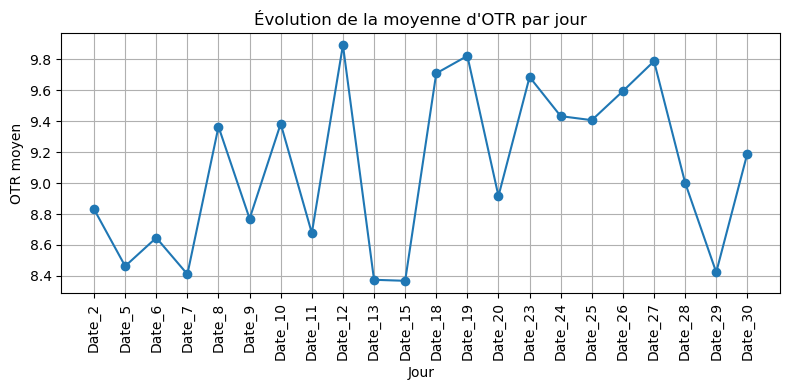

In [32]:
# Moyenne par jour
moyennes = df_x_train_features.groupby('Day')['OTR'].mean()

# On trie les dates selon le numéro après 'Date_'
moyennes.index = moyennes.index.str.extract('Date_(\d+)', expand=False).astype(int)
moyennes = moyennes.sort_index()
moyennes.index = ['Date_' + str(i) for i in moyennes.index]

plt.figure(figsize=(8, 4))
plt.plot(moyennes.index, moyennes.values, marker='o')
plt.title("Évolution de la moyenne d'OTR par jour")
plt.xlabel("Jour")
plt.ylabel("OTR moyen")
plt.xticks(rotation=90)  # rotation à 90° pour tout voir clairement
plt.grid(True)
plt.tight_layout()
plt.show()

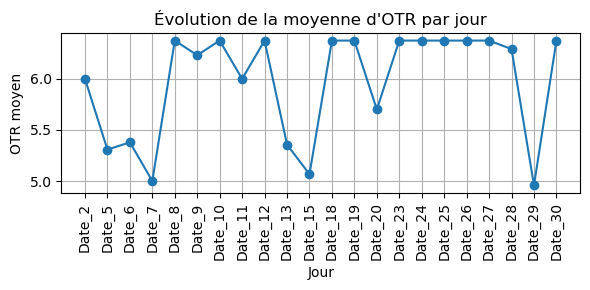

In [33]:
# Médiane par jour
medianes = df_x_train_features.groupby('Day')['OTR'].median()

# On trie les dates selon le numéro après 'Date_'
medianes.index = medianes.index.str.extract('Date_(\d+)', expand=False).astype(int)
medianes = medianes.sort_index()
medianes.index = ['Date_' + str(i) for i in medianes.index]

plt.figure(figsize=(6, 3))
plt.plot(medianes.index, medianes.values, marker='o')
plt.title("Évolution de la moyenne d'OTR par jour")
plt.xlabel("Jour")
plt.ylabel("OTR moyen")
plt.xticks(rotation=90)  # rotation à 90° pour tout voir clairement
plt.grid(True)
plt.tight_layout()
plt.show()

On remarque que la moyenne est plus volatile que la médiane, donc on pourrait se dire que savoir si un trader se situe au-dessus ou en dessous de la médiane serait un bon feature pour savoir si le trader à beaucoup trader par rapport aux autres.
Néanmoins, ici on essaie de faire des catégories qui regroupent différents types de traders. Donc, dans ce contexte il est plus pertinent de prendre la médiane pour savoir si le trader a passé plus d'ordres que 50% des autres ce jour là.

In [34]:
df_x_train_features['dummy_over_median'] = (
    df_x_train_features['OTR'] > df_x_train_features.groupby('Day')['OTR'].transform('median')
).astype(int)
sum(df_x_train_features['dummy_over_median']) # Il y a environ 40 000 lignes où les traders sont au dessus de la médiane 
                                             # à cette date
df_x_train_features.groupby('Trader')['dummy_over_median'].unique()

Trader
Trader_10     [0, 1]
Trader_105    [0, 1]
Trader_107    [0, 1]
Trader_110       [0]
Trader_114    [0, 1]
               ...  
Trader_51     [1, 0]
Trader_54     [0, 1]
Trader_57     [1, 0]
Trader_59     [0, 1]
Trader_60        [0]
Name: dummy_over_median, Length: 86, dtype: object

In [35]:
# On effectue la même opération que pour la dummy sur le nombre de plateforme
df_x_train_features['au_moins_une_fois_over_median'] = df_x_train_features.groupby('Trader')['dummy_over_median'].transform('max')
df_x_train_features.groupby('Trader')['au_moins_une_fois_over_median'].unique()

Trader
Trader_10     [1]
Trader_105    [1]
Trader_107    [1]
Trader_110    [0]
Trader_114    [1]
             ... 
Trader_51     [1]
Trader_54     [1]
Trader_57     [1]
Trader_59     [1]
Trader_60     [0]
Name: au_moins_une_fois_over_median, Length: 86, dtype: object

maintenant on a une colonne qui répond à la question : "est-ce que le trader passé plus d'ordre que la médiane au moins un jour ?"

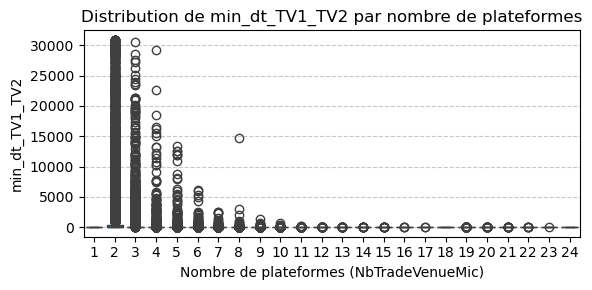

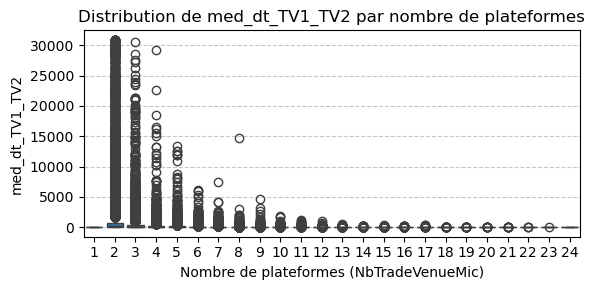

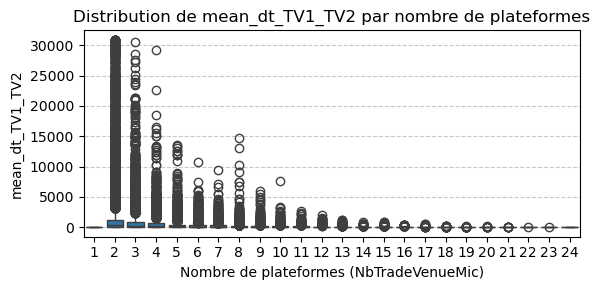

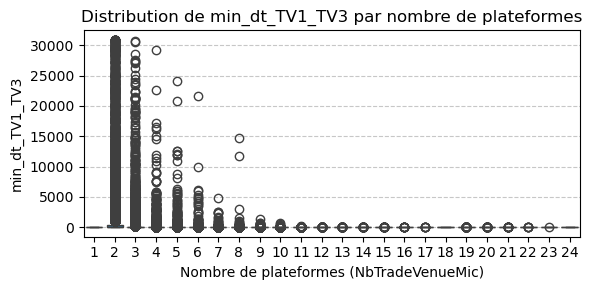

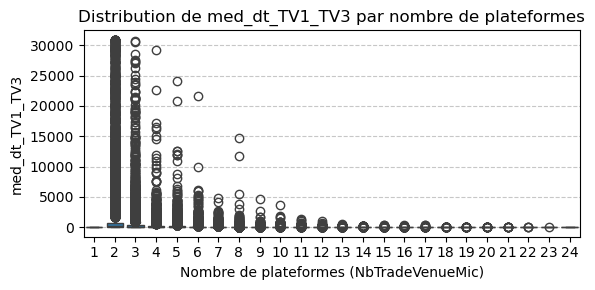

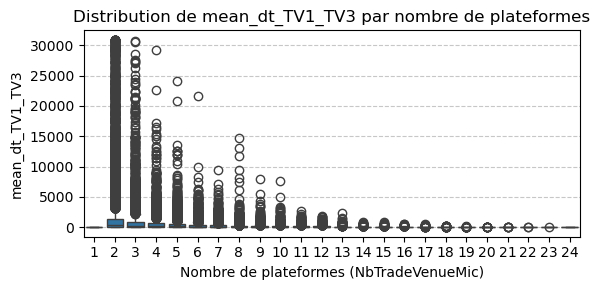

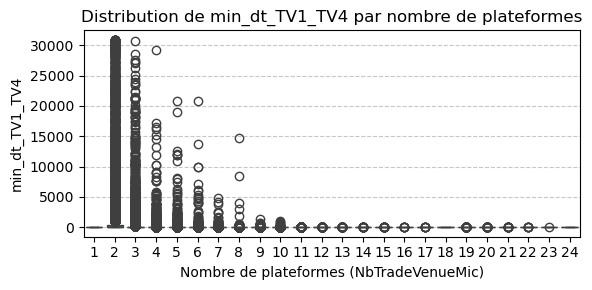

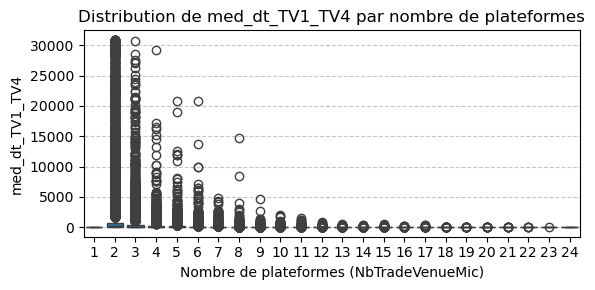

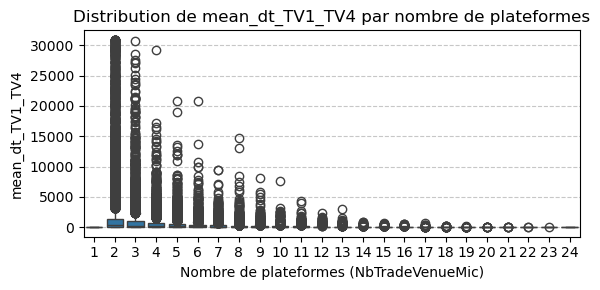

In [36]:
# Créer un graphique pour chaque colonne
for column in platform_columns:
    plt.figure(figsize=(6, 3))
    
    # Filtrer les données pour enlever les NA
    data = df_x_train_clean[[column, 'NbTradeVenueMic']].dropna()
    
    # Créer un boxplot pour visualiser la distribution
    sns.boxplot(x='NbTradeVenueMic', y=column, data=data)
    
    plt.title(f'Distribution de {column} par nombre de plateformes')
    plt.xlabel('Nombre de plateformes (NbTradeVenueMic)')
    plt.ylabel(column)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

On remarque que plus il ya de plateformes sur lesquels le trader effectue ses opérations et moins le detla est grand en moyenne. On remarque également qu'au dessus de 4 plateformes le delta réduit drastiquement, et pour 3 les valeurs sont concentrée en dessous de 5 000 secondes, on choisit donc un seuil en dessous de 5 000 secondes pour créer notre nouveau feature qui répondra à la question : "quels sont les traders qui on in delta environ de moins de 5 000 sec entre les plateformes ?"

In [37]:
less_than_5000 = (df_x_train[platform_columns] < 100) & (df_x_train[platform_columns] != -1)
# Créer la colonne dummy_delta
# any(axis=1) retourne True si au moins une valeur dans la ligne est True
df_x_train_features['dummy_delta'] = less_than_5000.any(axis=1).astype(int)
# Identification des traders qui ont eu un delta plus petit que 5 000 au moins une fois
df_x_train_features['dummy_delta'] = df_x_train_features.groupby('Trader')['dummy_delta'].transform('max')

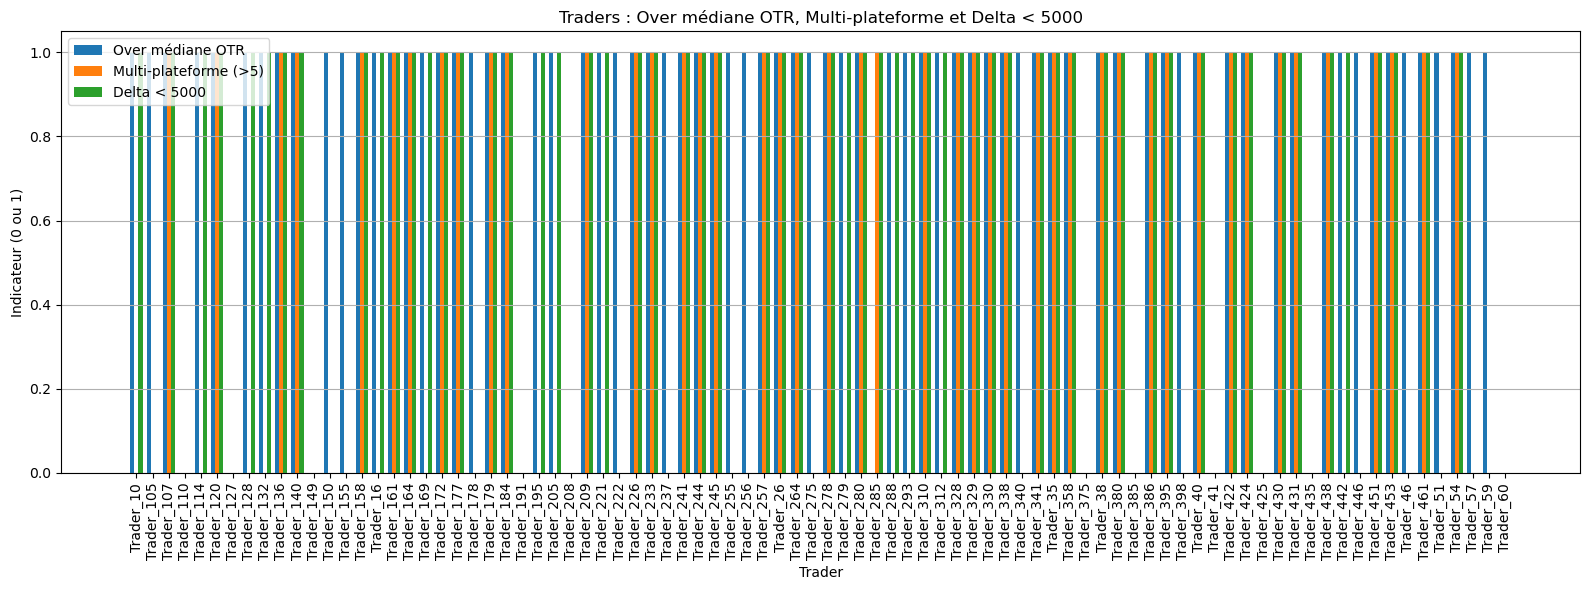

In [38]:
# Récupération des trois indicateurs
df_indic = df_x_train_features.groupby('Trader')[
    ['au_moins_une_fois_over_median', 'trader_au_moins_une_fois_multiplateforme', 'dummy_delta']
].max()

# Position sur l'axe des x
x = np.arange(len(df_indic))  # une position par trader
bar_width = 0.25  # Réduit pour accommoder 3 barres au lieu de 2

# Création du graphique
plt.figure(figsize=(16, 6))
plt.bar(x - bar_width, df_indic['au_moins_une_fois_over_median'], width=bar_width, label='Over médiane OTR')
plt.bar(x, df_indic['trader_au_moins_une_fois_multiplateforme'], width=bar_width, label='Multi-plateforme (>5)')
plt.bar(x + bar_width, df_indic['dummy_delta'], width=bar_width, label='Delta < 5000')

# Labels
plt.xticks(x, df_indic.index, rotation=90)
plt.ylabel("Indicateur (0 ou 1)")
plt.xlabel("Trader")
plt.title("Traders : Over médiane OTR, Multi-plateforme et Delta < 5000")
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [39]:
# Création d'un dataframe propre, sans les variables dont sont issues les features
df_with_features = df_x_train_features.copy()
df_with_features = df_with_features.drop(platform_columns, axis=1)  # Spécifier axis=1 pour supprimer des colonnes
df_with_features

,Share,Day,Trader,OTR,OCR,min_time_two_events,mean_time_two_events,10_p_time_two_events,med_time_two_events,25_p_time_two_events,...,max_lifetime_cancel,NbTradeVenueMic,MaxNbTradesBySecond,MeanNbTradesBySecond,NbSecondWithAtLeatOneTrade,dummy_nb_plateforme,trader_au_moins_une_fois_multiplateforme,dummy_over_median,au_moins_une_fois_over_median,dummy_delta
Index,,,,,,,,,,,,,,,,,,,,,
1,Isin_8,Date_24,Trader_10,2.272727,8.333333,0.0,5117.830300,0.000000,10.060561,0.068562,...,23151.8380,1,7,2.750000,4,0,0,0,1,1
2,Isin_87,Date_29,Trader_10,1.696629,25.166667,0.0,1846.968401,0.000074,0.003374,0.000204,...,21433.6840,1,17,1.839598,15,0,0,0,1,1
3,Isin_87,Date_23,Trader_10,1.482759,5.352158,0.0,686.300630,0.000071,0.000599,0.000129,...,10842.4640,1,20,1.839598,63,0,0,0,1,1
4,Isin_12,Date_11,Trader_10,1.705882,14.500000,0.0,2174.335265,0.000000,6.152666,0.000945,...,19187.7190,1,8,1.839598,4,0,0,0,1,1
5,Isin_87,Date_9,Trader_10,1.517730,26.750000,0.0,944.008551,0.000071,0.001364,0.000146,...,23164.5140,1,19,1.839598,38,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105778,Isin_84,Date_27,Trader_60,1.150000,23.000000,0.0,736.500080,0.000000,0.000188,0.000039,...,7609.9443,1,15,1.839598,3,0,0,0,0,0
105779,Isin_102,Date_18,Trader_60,1.352941,23.000000,0.0,63.672695,0.000000,0.000963,0.000176,...,567.1530,1,4,2.428571,7,0,0,0,0,0
105780,Isin_12,Date_13,Trader_60,1.146667,5.352158,0.0,708.440816,0.000000,0.000578,0.000062,...,23448.5250,1,21,1.839598,16,0,0,0,0,0


## 7. PCA et réduction de la dimensionalité

### Etude de PCA et autre

In [28]:
print("Colonnes disponibles dans df_x_train_cleaned:", df_x_train_cleaned.columns.tolist())
numeric_cols = df_x_train_cleaned.select_dtypes(include=['number']).columns
print("Colonnes numériques disponibles:", numeric_cols.tolist())

# Créez une copie sécurisée
df_x_train_final = df_x_train_cleaned[numeric_cols].copy()


Colonnes disponibles dans df_x_train_cleaned: ['Share', 'Day', 'Trader', 'OTR', 'OCR', 'min_time_two_events', 'mean_time_two_events', '10_p_time_two_events', 'med_time_two_events', '25_p_time_two_events', '75_p_time_two_events', '90_p_time_two_events', 'max_time_two_events', 'min_lifetime_cancel', 'mean_lifetime_cancel', '10_p_lifetime_cancel', 'med_lifetime_cancel', '25_p_lifetime_cancel', '75_p_lifetime_cancel', '90_p_lifetime_cancel', 'max_lifetime_cancel', 'NbTradeVenueMic', 'MaxNbTradesBySecond', 'MeanNbTradesBySecond', 'min_dt_TV1_TV2', 'mean_dt_TV1_TV2', 'med_dt_TV1_TV2', 'min_dt_TV1_TV3', 'mean_dt_TV1_TV3', 'med_dt_TV1_TV3', 'min_dt_TV1_TV4', 'mean_dt_TV1_TV4', 'med_dt_TV1_TV4', 'NbSecondWithAtLeatOneTrade']
Colonnes numériques disponibles: ['OTR', 'OCR', 'min_time_two_events', 'mean_time_two_events', '10_p_time_two_events', 'med_time_two_events', '25_p_time_two_events', '75_p_time_two_events', '90_p_time_two_events', 'max_time_two_events', 'min_lifetime_cancel', 'mean_lifetime

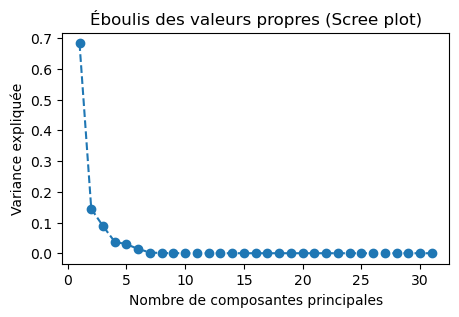

In [29]:
# Appliquer l’ACP
pca = PCA()
pca.fit(df_x_train_final)

# Tracer l’éboulis des valeurs propres
plt.figure(figsize=(5,3))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_, marker='o', linestyle='--')
plt.xlabel('Nombre de composantes principales')
plt.ylabel('Variance expliquée')
plt.title('Éboulis des valeurs propres (Scree plot)')
plt.show()

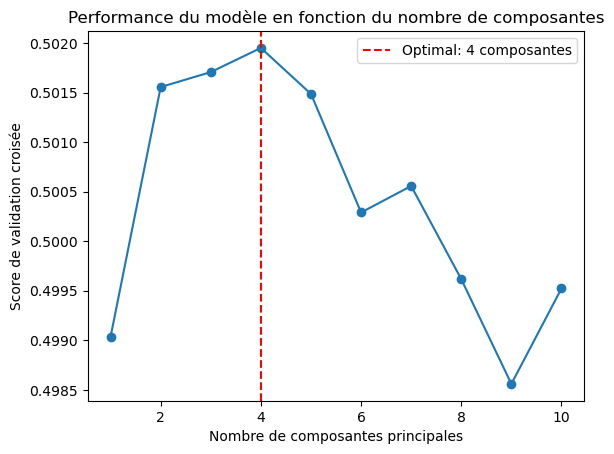

Le meilleur nombre de composantes principales est 4 avec un score de validation croisée de 0.5020


In [30]:
# Initialisation des variables pour stocker les scores et le meilleur modèle
scores = []
best_score = -np.inf  # Initialisation avec une valeur très basse
best_k = None  # Stocker le nombre optimal de composantes principales
np.random.seed(200)
y_random = np.random.randint(0, 2, 86074)
# Tester différents nombres de composantes principales
for k in range(1, 11):  
    model = make_pipeline(PCA(n_components=k), LogisticRegression())
    
    # Calcul du score de validation croisée
    score = np.mean(cross_val_score(model, df_x_train_standardized, y_random, cv=5))
    scores.append(score)

    # Vérifier si c'est le meilleur score
    if score > best_score:
        best_score = score
        best_k = k  # Mémoriser la meilleure valeur de k

# Tracer la performance du modèle
plt.plot(range(1, 11), scores, marker='o', linestyle='-')
plt.xlabel('Nombre de composantes principales')
plt.ylabel('Score de validation croisée')
plt.title('Performance du modèle en fonction du nombre de composantes')

# Marquer le nombre optimal de composantes principales
plt.axvline(best_k, color='r', linestyle='--', label=f'Optimal: {best_k} composantes')
plt.legend()
plt.show()

# Affichage du meilleur nombre de composantes principales et du score correspondant
print(f"Le meilleur nombre de composantes principales est {best_k} avec un score de validation croisée de {best_score:.4f}")

Exécution de PCA sans standardisation...
PCA sans standardisation - Temps: 0.11s
Variance expliquée: 95.38%
Erreur de reconstruction: 1696794.0581
Score de classification: 0.4779

Exécution de PCA avec standardisation...
PCA avec standardisation - Temps: 0.09s
Variance expliquée: 51.09%
Erreur de reconstruction: 12072418.9007
Score de classification: 0.6213


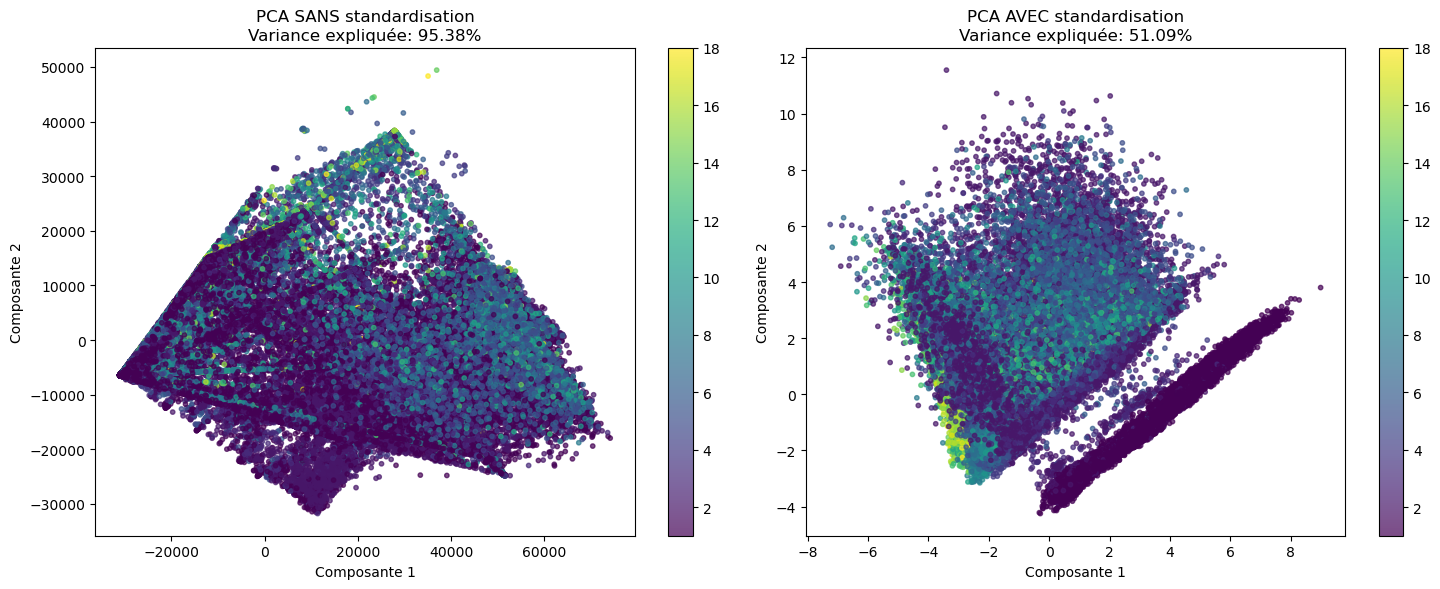


Exécution de t-SNE...


In [ ]:

# 1. Préparation des données
numeric_cols = df_x_train_cleaned.select_dtypes(include=['number']).columns
data = df_x_train_cleaned[numeric_cols].copy()

# variable cible => A CHOISIR ??
if 'NbTradeVenueMic' in df_x_train_cleaned.columns:
    target = df_x_train_cleaned['NbTradeVenueMic'].values
else:
    target = df_x_train_cleaned['OTR'].values if 'OTR' in df_x_train_cleaned.columns else None

# Discrétisation pour la classification - avec gestion des duplicats
if target is not None and np.issubdtype(type(target[0]), np.number):
    try:
        # Essayer d'abord avec l'option de gestion des duplicats
        target_classes = pd.qcut(target, q=5, labels=False, duplicates='drop')
    except ValueError:
        # Si trop de valeurs répétées, utiliser une approche plus simple
        target_classes = pd.cut(target, bins=5, labels=False)
else:
    target_classes = target

#### ETUDE DE LA PCA ######
# 2. PCA sans standardisation
print("Exécution de PCA sans standardisation...")
start_time = time.time()
pca_raw = PCA(n_components=4)
data_pca_raw = pca_raw.fit_transform(data)
pca_raw_time = time.time() - start_time

# Calcul des métriques principales
variance_raw = np.sum(pca_raw.explained_variance_ratio_) * 100
reconstruction_raw = np.mean(np.square(data - pca_raw.inverse_transform(data_pca_raw)))

if target_classes is not None:
    knn = KNeighborsClassifier(n_neighbors=5)
    clf_score_raw = np.mean(cross_val_score(knn, data_pca_raw, target_classes, cv=3))
else:
    clf_score_raw = np.nan

print(f"PCA sans standardisation - Temps: {pca_raw_time:.2f}s")
print(f"Variance expliquée: {variance_raw:.2f}%")
print(f"Erreur de reconstruction: {reconstruction_raw:.4f}")
print(f"Score de classification: {clf_score_raw:.4f}")

# 3. PCA avec standardisation
print("\nExécution de PCA avec standardisation...")
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

start_time = time.time()
pca_scaled = PCA(n_components=4)   # On a retenu que 4 c'était optimal plus haut
data_pca_scaled = pca_scaled.fit_transform(data_scaled)
pca_scaled_time = time.time() - start_time

variance_scaled = np.sum(pca_scaled.explained_variance_ratio_) * 100
reconstruction_scaled = np.mean(np.square(data - scaler.inverse_transform(pca_scaled.inverse_transform(data_pca_scaled))))

if target_classes is not None:
    knn = KNeighborsClassifier(n_neighbors=5)
    clf_score_scaled = np.mean(cross_val_score(knn, data_pca_scaled, target_classes, cv=5))
else:
    clf_score_scaled = np.nan

print(f"PCA avec standardisation - Temps: {pca_scaled_time:.2f}s")
print(f"Variance expliquée: {variance_scaled:.2f}%")
print(f"Erreur de reconstruction: {reconstruction_scaled:.4f}")
print(f"Score de classification: {clf_score_scaled:.4f}")

##### GRAPHS DES PCA #####
plt.figure(figsize=(15, 6))

# PCA sans standardisation
plt.subplot(1, 2, 1)
scatter = plt.scatter(data_pca_raw[:, 0], data_pca_raw[:, 1], c=target, cmap='viridis', s=10, alpha=0.7)
plt.title(f'PCA SANS standardisation\nVariance expliquée: {np.sum(pca_raw.explained_variance_ratio_):.2%}')
plt.colorbar(scatter)
plt.xlabel('Composante 1')
plt.ylabel('Composante 2')

# PCA avec standardisation
plt.subplot(1, 2, 2)
scatter = plt.scatter(data_pca_scaled[:, 0], data_pca_scaled[:, 1], c=target, cmap='viridis', s=10, alpha=0.7)
plt.title(f'PCA AVEC standardisation\nVariance expliquée: {np.sum(pca_scaled.explained_variance_ratio_):.2%}')
plt.colorbar(scatter)
plt.xlabel('Composante 1')
plt.ylabel('Composante 2')

plt.tight_layout()
plt.savefig('comparaison_pca_standardisation.png')
plt.show()


##### AUTRES METHODES t-SNE et UMAP ######
# 4. t-SNE sur données non standardisées
print("\nExécution de t-SNE...")
start_time = time.time()
tsne = TSNE(n_components=2, random_state=42)
data_tsne = tsne.fit_transform(data)
tsne_time = time.time() - start_time

if target_classes is not None:
    knn = KNeighborsClassifier(n_neighbors=5)
    clf_score_tsne = np.mean(cross_val_score(knn, data_tsne, target_classes, cv=3))
else:
    clf_score_tsne = np.nan

print(f"t-SNE - Temps: {tsne_time:.2f}s")
print(f"Score de classification: {clf_score_tsne:.4f}")

"""""
# 5. UMAP sur données non standardisées
print("\nExécution de UMAP...")
start_time = time.time()
#umap_model = UMAP(n_components=2, random_state=42)
data_umap = umap_model.fit_transform(data)
umap_time = time.time() - start_time

if target_classes is not None:
    knn = KNeighborsClassifier(n_neighbors=5)
    clf_score_umap = np.mean(cross_val_score(knn, data_umap, target_classes, cv=3))
else:
    clf_score_umap = np.nan

print(f"UMAP - Temps: {umap_time:.2f}s")
print(f"Score de classification: {clf_score_umap:.4f}")

"""
# 6. Résumé des mesures 
print("\n--- Recommandations ---")
methods = {
    "PCA (sans standardisation)": {"variance": variance_raw, "reconstruction": reconstruction_raw, "classification": clf_score_raw},
    "PCA (avec standardisation)": {"variance": variance_scaled, "reconstruction": reconstruction_scaled, "classification": clf_score_scaled},
    "t-SNE": {"classification": clf_score_tsne},
    #"UMAP": {"classification": clf_score_umap}
}

best_variance = max([(k, v["variance"]) for k, v in methods.items() if "variance" in v], key=lambda x: x[1])
best_reconstruction = min([(k, v["reconstruction"]) for k, v in methods.items() if "reconstruction" in v], key=lambda x: x[1])
best_classification = max([(k, v["classification"]) for k, v in methods.items() if "classification" in v], key=lambda x: x[1])

print(f"Meilleure variance expliquée: {best_variance[0]} ({best_variance[1]:.2f}%)")
print(f"Meilleure erreur de reconstruction: {best_reconstruction[0]} ({best_reconstruction[1]:.4f})")
print(f"Meilleur score de classification: {best_classification[0]} ({best_classification[1]:.4f})")

In [ ]:
plt.figure(figsize=(20, 6))

# PCA Plot
plt.subplot(1, 3, 1)
scatter = plt.scatter(data_pca_raw[:, 0], data_pca_raw[:, 1], c=target, cmap='viridis', s=5, alpha=0.8)
plt.title(f'PCA (temps: {pca_raw_time:.2f}s)\nVariance expliquée: {np.sum(pca_raw.explained_variance_ratio_):.2%}')
plt.colorbar(scatter)
plt.xlabel('Composante 1')
plt.ylabel('Composante 2')

# t-SNE Plot
plt.subplot(1, 3, 2)
scatter = plt.scatter(data_tsne[:, 0], data_tsne[:, 1], c=target, cmap='viridis', s=5, alpha=0.8)
plt.title(f't-SNE (temps: {tsne_time:.2f}s)')
plt.colorbar(scatter)
plt.xlabel('Composante 1')
plt.ylabel('Composante 2')

# UMAP Plot
plt.subplot(1, 3, 3)
scatter = plt.scatter(data_umap[:, 0], data_umap[:, 1], c=target, cmap='viridis', s=5, alpha=0.8)
plt.title(f'UMAP (temps: {umap_time:.2f}s)')
plt.colorbar(scatter)
plt.xlabel('Composante 1')
plt.ylabel('Composante 2')

plt.tight_layout()
plt.savefig('comparaison_methodes_sans_standardisation.png')
plt.show()


La standardisation réduit considérablement la variance expliquée (de 82.82% à 32.60%). Cela indique que sans standardisation, la PCA est dominée par les variables ayant les plus grandes échelles ou variances. Après standardisation, toutes les variables contribuent plus équitablement.

### K-Means et clustering

Nous allons désormais étudier les potentiels clusters. Cela pourrait nous donner des idées de features à ajouter, ou bien aguiller notre PCA. Chaque cluster regroupe des points de données similaires selon les composantes principales retenues. Cela peut révéler des patterns ou des sous-groupes dans l'ensemble de données qui ne sont pas immédiatement apparents.

In [ ]:
pca = PCA(n_components=4)  
X_pca = pca.fit_transform(X)

# KMeans Clustering
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(X_pca)

# Ajout des labels de cluster aux données
X['cluster'] = clusters

centroid_features = kmeans.cluster_centers_[clusters]
for i in range(centroid_features.shape[1]):
    X[f'centroid_{i}'] = centroid_features[:, i]


### Réduction de la dimensionalité

Nous avons créé une fonction, dont l'objectif est de nous aider à réduire la dimensionalité des données. 
Effectivement, en faisant une étude sur les clusters Kmeans ainsi que l'analyse en composantes principales, nous avons remarqué que conserver toutes les colonnes était inutile. 

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def reduce_dimensionality(df, standardize=True, variance_threshold=0.01, 
                           correlation_threshold=0.95, pca_variance=0.95):
    """
    Fonction complète pour réduire la dimensionnalité d'un DataFrame
    
    Args:
        df: DataFrame d'entrée
        standardize: Booléen indiquant si les données doivent être standardisées
        variance_threshold: Seuil pour éliminer les variables à faible variance
        correlation_threshold: Seuil pour éliminer les variables corrélées
        pca_variance: Pourcentage de variance à conserver dans la PCA
    
    Returns:
        DataFrame réduit, informations sur la réduction
    """
    # Séparer les colonnes numériques et non-numériques
    numeric_cols = df.select_dtypes(include=['number']).columns
    non_numeric_cols = df.select_dtypes(exclude=['number']).columns
    
    # Copier les données numériques
    data = df[numeric_cols].copy()
    
    # Étape 1: Standardisation (si demandée)
    if standardize:
        scaler = StandardScaler()
        data_processed = scaler.fit_transform(data)
    else:
        data_processed = data.values
    
    # Étape 2: Éliminer les variables à faible variance
    selector = VarianceThreshold(threshold=variance_threshold)
    data_var_reduced = selector.fit_transform(data_processed)
    
    # Obtenir les colonnes conservées
    var_mask = selector.get_support()
    var_selected_features = [numeric_cols[i] for i in range(len(numeric_cols)) if var_mask[i]]
    
    # Étape 3: Éliminer les variables fortement corrélées
    corr_matrix = df[var_selected_features].corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > correlation_threshold)]
    corr_selected_features = [f for f in var_selected_features if f not in to_drop]
    
    # Étape 4: Appliquer la PCA pour réduire davantage si nécessaire
    data_corr_reduced = df[corr_selected_features].values
    if standardize:
        data_corr_reduced = scaler.fit_transform(data_corr_reduced)
    
    # Calculer l'importance des variables avant PCA
    feature_importance = pd.DataFrame({
        'Feature': corr_selected_features,
        'Variance': np.var(data_corr_reduced, axis=0)
    })
    feature_importance = feature_importance.sort_values('Variance', ascending=False)
    
    # Appliquer la PCA
    pca = PCA()
    pca.fit(data_corr_reduced)
    
    # Trouver le nombre de composantes pour atteindre le seuil de variance
    explained_variance_ratio_cumsum = np.cumsum(pca.explained_variance_ratio_)
    n_components = np.argmax(explained_variance_ratio_cumsum >= pca_variance) + 1
    
    # Créer un DataFrame de composantes principales
    pca_final = PCA(n_components=n_components)
    data_pca = pca_final.fit_transform(data_corr_reduced)
    pca_cols = [f'PC{i+1}' for i in range(n_components)]
    df_pca = pd.DataFrame(data_pca, columns=pca_cols)
    
    # Créer un DataFrame réduit basé sur les variables d'origine les plus importantes
    df_top_features = df[corr_selected_features[:n_components]]
    
    # Ajouter les colonnes non-numériques importantes aux deux DataFrames
    for col in non_numeric_cols:
        df_pca[col] = df[col].reset_index(drop=True)
        df_top_features[col] = df[col].reset_index(drop=True)
    
    # Informations sur la réduction
    info = {
        'original_shape': df.shape,
        'reduced_shape_features': df_top_features.shape,
        'reduced_shape_pca': df_pca.shape,
        'variance_explained': explained_variance_ratio_cumsum[n_components-1],
        'features_removed_by_variance': len(numeric_cols) - len(var_selected_features),
        'features_removed_by_correlation': len(var_selected_features) - len(corr_selected_features),
        'pca_components': n_components,
        'top_features': corr_selected_features[:n_components]
    }
    
    # Visualisations
    plt.figure(figsize=(12, 5))
    
    # Graphique de variance expliquée
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(pca.explained_variance_ratio_)+1), 
             np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='-')
    plt.axhline(y=pca_variance, color='r', linestyle='--')
    plt.title(f'Variance cumulée expliquée (seuil: {pca_variance})')
    plt.xlabel('Nombre de composantes')
    plt.ylabel('Variance cumulée')
    plt.grid(True, alpha=0.3)
    
    # Importance des variables
    plt.subplot(1, 2, 2)
    sns.barplot(x='Variance', y='Feature', data=feature_importance.head(10))
    plt.title('10 variables les plus importantes')
    plt.tight_layout()
    plt.show()
    
    return df_top_features, df_pca, info

# Appliquer la fonction
df_reduced_features, df_reduced_pca, reduction_info = reduce_dimensionality(
    df_x_train_cleaned, 
    standardize=False, 
    variance_threshold=0.1,
    correlation_threshold=0.95,
    pca_variance=0.95
)

# Afficher les informations sur la réduction
print("Informations sur la réduction de dimensionnalité:")
for key, value in reduction_info.items():
    print(f"{key}: {value}")

print("\nVariables les plus importantes conservées:")
for i, feature in enumerate(reduction_info['top_features']):
    print(f"{i+1}. {feature}")

## 8. Modèle non-supervisé